<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/05_Relation_Extraction/REBEL.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
      alt="Open in Colab">
</a>


# REBEL (Relation Extraction By End-to-end Language generation)

## 1. Introduction

Relation Extraction is the last NLP technique and final step in the Information Extraction pipeline for extracting structured information from unstructured text. It is the process of identifying the relationships between entities in the text and is most commonly output as a list of triples with head and tail entities and the relationship type.

Early approaches were based on co-occurring entities in the same sentence or abstract. Rule-based approaches extracted relations according to predefined rules, such as part-of-speech tagging and dependency parsing, constructing subject-verb-object (SVO) triples. To overcome limitations, machine learning approaches were introduced, but required large annotated training and testing datasets proving labour-intensive and costly.

Neural network-based approaches utilised pretrained deep learning models to extract relations at sentence or document level. BERT-based models such as BioBERT performed well on language understanding tasks.

More recently, LLMs have changed the NLP landscape, particularly in the biomedical domain, with GPT-style text generation models being applied to a range of BioNLP tasks including relation extraction.


Here we will use [REBEL](https://github.com/Babelscape/rebel), a seq2seq model developed by [Babelscape](https://babelscape.com/) based on the BART encoder-decoder transformer architecture, that presents a new linearisation approach and performs end-to-end entity and relation extraction for more than 200 different relation types.


The REBEL output will then be normalised by prompting Llama3-70b and Llama3-8b models, supported by [Groq](https://console.groq.com/playground)'s AI inference API, to identify canonical entities and replace synonyms.



## 2. Install/import libraries

In [ ]:
!pip install transformers pyvis networkx thefuzz

In [ ]:
!pip install -q groq

In [ ]:
import torch
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import json
import time
import math
import IPython
import warnings
warnings.filterwarnings("ignore")


from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from IPython.display import display, HTML
from pyvis.network import Network
from collections import Counter
from thefuzz import process

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 3. REBEL

There are [different methods](https://github.com/Babelscape/rebel/issues/41) for generating triplets with REBEL - using a Hugging Face pipeline, as a spaCy component, or directly with the `transformers` library and `generate()` function.

We will try the pipeline usage and then the `transformers` library, as described in the [model card](https://huggingface.co/Babelscape/rebel-large), for a test sentence.






### 3.1 Pipeline usage

The Hugging Face `pipeline()` function simplifies the model initialisation process by allowing you to specify the task (`text2text-generation`), model (`rebel-large`, pretrained for triplet extraction tasks), and tokeniser with minimal code and configuration.

In [ ]:
from transformers import pipeline

In [ ]:
# Initialise model pipeline
triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large')

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

In [ ]:
# We need to use the tokeniser manually since we need special tokens.
extracted_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor("Molnupiravir is a repurposed Covid-19 medicine that was specifically developed to cure influenza and is used to treat mild to moderately ill Covid-19 patients with high risk of becoming seriously ill.", return_tensors=True, return_text=False)[0]["generated_token_ids"]])
print(extracted_text[0])

<s><triplet> Molnupiravir <subj> influenza <obj> medical condition treated <triplet> influenza <subj> Molnupiravir <obj> drug used for treatment</s>


In [ ]:
# from model card at https://huggingface.co/Babelscape/rebel-large

# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

In [ ]:
extracted_triplets = extract_triplets(extracted_text[0])
extracted_triplets

[{'head': 'Molnupiravir',
  'type': 'medical condition treated',
  'tail': 'influenza'},
 {'head': 'influenza',
  'type': 'drug used for treatment',
  'tail': 'Molnupiravir'}]

### 3.2 Model and Tokeniser using transformers

To have full control over all model parameters, the method using `transformers` and the `generate()` function is the best way.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
# extraction code from model card at https://huggingface.co/Babelscape/rebel-large

# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

We will load the pretrained model and tokeniser, and specify generation kwargs to pass to the `generate()` function to control the model's behaviour through decoding strategy and parameters:

* `max_length` sets a maximum number of tokens for the generated text.

* `length_penalty` adjusts the scoring of generated sequences based on their length. 0 means no penalty so longer and shorter sequences will have equal priority. Increasing the penalty will make generations longer and obtain more triplets from a given input but may lead to more hallucination. Decreasing the penalty will encourage the model to generate shorter sequences.

* Beam search is a decoding algorithm commonly used in NLP to generate sequences from a model. It provides a trade-off between accuracy and computational cost via the flexible choice of the beam size. It keeps the most likely `num_beams` of hypotheses at each time step, eventually choosing the hypothesis that has the highest overall probability.

* Another important feature about beam search is that we can compare the top beams after generation and choose the generated beam that best fits our purpose. We simply set `num_return_sequences` to the number of highest scoring beams that should be returned, ensuring that `num_return_sequences <= num_beams`.



In [ ]:
# Load model and tokeniser and set gen_kwargs
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
gen_kwargs = {
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 30,
    "num_return_sequences": 30,
}

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
# Text to extract triplets from
text = 'Molnupiravir is a repurposed Covid-19 medicine that was specifically developed to cure influenza and is used to treat mild to moderately ill Covid-19 patients with high risk of becoming seriously ill.'

In [ ]:
# Tokeniser text
model_inputs = tokenizer(text, max_length=256, padding=True, truncation=True, return_tensors = 'pt')

In [ ]:
# Generate
generated_tokens = model.generate(
    model_inputs["input_ids"].to(model.device),
    attention_mask=model_inputs["attention_mask"].to(model.device),
    **gen_kwargs,
)

In [ ]:
# Extract text
decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

In [ ]:
# Extract triplets
for idx, sentence in enumerate(decoded_preds):
    #print(f'Prediction triplets sentence {idx}')
    print(extract_triplets(sentence))

[{'head': 'Molnupiravir', 'type': 'medical condition treated', 'tail': 'influenza'}, {'head': 'influenza', 'type': 'drug used for treatment', 'tail': 'Molnupiravir'}]
[{'head': 'influenza', 'type': 'drug used for treatment', 'tail': 'Molnupiravir'}]
[{'head': 'Molnupiravir', 'type': 'medical condition treated', 'tail': 'influenza'}]
[{'head': 'Molnupiravir', 'type': 'medical condition treated', 'tail': 'influenza'}, {'head': 'influenza', 'type': 'drug used for treatment', 'tail': 'Molnupiravir'}, {'head': 'influenza', 'type': 'drug used for treatment', 'tail': 'Covid-19 medicine'}]
[{'head': 'influenza', 'type': 'drug used for treatment', 'tail': 'Covid-19 medicine'}]
[{'head': 'Covid-19', 'type': 'has effect', 'tail': 'influenza'}, {'head': 'influenza', 'type': 'has cause', 'tail': 'Covid-19'}]
[{'head': 'Covid-19 medicine', 'type': 'medical condition treated', 'tail': 'influenza'}, {'head': 'influenza', 'type': 'drug used for treatment', 'tail': 'Covid-19 medicine'}]
[{'head': 'Covid

We will define a function to generate triples by using the `transformers` library and calling the `extract_triplets` function.

In [ ]:
def generate_triples(texts):
    triples = []

    # Tokenise text
    model_inputs = tokenizer(text, max_length=256, padding=True, truncation=True, return_tensors = 'pt')

    # Generate
    generated_tokens = model.generate(
        model_inputs["input_ids"].to(model.device),
        attention_mask=model_inputs["attention_mask"].to(model.device),
        **gen_kwargs,
    )

    # Extract text
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    for idx, sentence in enumerate(decoded_preds):
        extracted_triplets = extract_triplets(sentence)
        for triplet in extracted_triplets:
            triples.append((triplet['head'], triplet['type'], triplet['tail']))

    return triples

In [ ]:
extracted_triplets = generate_triples(text)

In [ ]:
len(extracted_triplets)

58

In [ ]:
extracted_triplets

[('Molnupiravir', 'medical condition treated', 'influenza'),
 ('influenza', 'drug used for treatment', 'Molnupiravir'),
 ('influenza', 'drug used for treatment', 'Molnupiravir'),
 ('Molnupiravir', 'medical condition treated', 'influenza'),
 ('Molnupiravir', 'medical condition treated', 'influenza'),
 ('influenza', 'drug used for treatment', 'Molnupiravir'),
 ('influenza', 'drug used for treatment', 'Covid-19 medicine'),
 ('influenza', 'drug used for treatment', 'Covid-19 medicine'),
 ('Covid-19', 'has effect', 'influenza'),
 ('influenza', 'has cause', 'Covid-19'),
 ('Covid-19 medicine', 'medical condition treated', 'influenza'),
 ('influenza', 'drug used for treatment', 'Covid-19 medicine'),
 ('Covid-19', 'has effect', 'influenza'),
 ('influenza', 'drug used for treatment', 'Covid-19'),
 ('Molnupiravir', 'subclass of', 'Covid-19 medicine'),
 ('Molnupiravir', 'medical condition treated', 'flu'),
 ('flu', 'drug used for treatment', 'Molnupiravir'),
 ('influenza', 'drug used for treatment

### 3.3 Filter for unique triples

In [ ]:
# Filter for unique triples
unique_triples = list(set(extracted_triplets))

In [ ]:
len(unique_triples)

19

Of the 58 extracted triples only 19 are unique.

In [ ]:
unique_triples

[('Molnupiravir', 'subclass of', 'Covid-19 medicine'),
 ('Covid-19', 'drug used for treatment', 'Molnupiravir'),
 ('influenza', 'drug used for treatment', 'Covid-19'),
 ('Covid-19 medicine', 'medical condition treated', 'influenza'),
 ('Molnupiravir', 'medical condition treated', 'flu'),
 ('Molnupiravir', 'instance of', 'Covid-19 medicine'),
 ('Molnupiravir', 'subclass of', 'Covid-19'),
 ('Molnupiravir', 'medical condition treated', 'Covid-19'),
 ('Covid-19 medicine', 'facet of', 'influenza'),
 ('flu', 'drug used for treatment', 'Molnupiravir'),
 ('Covid-19', 'subclass of', 'influenza'),
 ('influenza', 'subclass of', 'Covid-19'),
 ('Covid-19', 'has effect', 'influenza'),
 ('Molnupiravir', 'part of', 'Covid-19 medicine'),
 ('influenza', 'drug used for treatment', 'Molnupiravir'),
 ('influenza', 'has cause', 'Covid-19'),
 ('Molnupiravir', 'medical condition treated', 'influenza'),
 ('Molnupiravir', 'has effect', 'influenza'),
 ('influenza', 'drug used for treatment', 'Covid-19 medicine')

In [ ]:
with open('2024-06-25_rebel_test.pickle', "wb") as f:
    pickle.dump(unique_triples, f)

### 3.4 Remove hallucinations

The model has hallucinated the entity 'flu' which not does not explicitly appear in the sentence so we will filter this out.



In [ ]:
# Adapted from https://github.com/tomasonjo/blogs/blob/master/llm/Llamaindex-rebel-neo4j.ipynb

def clean_triplets(input_text, triplets):
    """Sometimes the model hallucinates, so we filter out entities
       not present in the text"""
    text = input_text.lower()
    clean_triplets = []
    for triplet in triplets:
        head, relation, tail = triplet

        if head == tail:
            continue

        head_match = re.search(r'\b' + re.escape(head.lower()) + r'\b', text)
        head_index = head_match.start() if head_match else text.find(head.lower())

        tail_match = re.search(r'\b' + re.escape(tail.lower()) + r'\b', text)
        tail_index = tail_match.start() if tail_match else text.find(tail.lower())

        if head_index == -1 or tail_index == -1:
            continue

        clean_triplets.append((head, relation, tail))

    return clean_triplets

In [ ]:
def extract_triplets(input_text):
    triplets = []
    relation, subject, object_ = '', '', ''
    current = 'x'
    for token in input_text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation:
                triplets.append((subject.strip(), relation.strip(), object_.strip()))
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation:
                triplets.append((subject.strip(), relation.strip(), object_.strip()))
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token

    if subject and relation and object_:
        triplets.append((subject.strip(), relation.strip(), object_.strip()))

    clean = clean_triplets(input_text, triplets)
    return clean

In [ ]:
# Load model and tokeniser
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")
gen_kwargs = {
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 30,
    "num_return_sequences": 30,
}

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
text = 'Molnupiravir is a repurposed Covid-19 medicine that was specifically developed to cure influenza and is used to treat mild to moderately ill Covid-19 patients with high risk of becoming seriously ill.'

In [ ]:
def generate_triples(text):
    triples = []

    # Tokenise text
    model_inputs = tokenizer(text, max_length=256, padding=True, truncation=True, return_tensors='pt')

    # Generate
    generated_tokens = model.generate(
        model_inputs["input_ids"].to(model.device),
        attention_mask=model_inputs["attention_mask"].to(model.device),
        **gen_kwargs,
    )

    # Extract text
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    for sentence in decoded_preds:
        extracted_triplets = extract_triplets(sentence)
        triples.extend(extracted_triplets)

    return triples

In [ ]:
extracted_triplets = generate_triples(text)

In [ ]:
len(extracted_triplets)

58

In [ ]:
extracted_triplets

[('Molnupiravir', 'medical condition treated', 'influenza'),
 ('influenza', 'drug used for treatment', 'Molnupiravir'),
 ('influenza', 'drug used for treatment', 'Molnupiravir'),
 ('Molnupiravir', 'medical condition treated', 'influenza'),
 ('Molnupiravir', 'medical condition treated', 'influenza'),
 ('influenza', 'drug used for treatment', 'Molnupiravir'),
 ('influenza', 'drug used for treatment', 'Covid-19 medicine'),
 ('influenza', 'drug used for treatment', 'Covid-19 medicine'),
 ('Covid-19', 'has effect', 'influenza'),
 ('influenza', 'has cause', 'Covid-19'),
 ('Covid-19 medicine', 'medical condition treated', 'influenza'),
 ('influenza', 'drug used for treatment', 'Covid-19 medicine'),
 ('Covid-19', 'has effect', 'influenza'),
 ('influenza', 'drug used for treatment', 'Covid-19'),
 ('Molnupiravir', 'subclass of', 'Covid-19 medicine'),
 ('Molnupiravir', 'medical condition treated', 'flu'),
 ('flu', 'drug used for treatment', 'Molnupiravir'),
 ('influenza', 'drug used for treatment

'Flu' still appears, perhaps because it is a partial match being a substring of influenza.  We will amend the code to exclude partial matches.

In [ ]:
def clean_triplets(input_text, triplets):
    """Sometimes the model hallucinates, so we filter out entities
       not present in the text"""
    text = input_text.lower()
    clean_triplets = []
    for triplet in triplets:
        head = triplet["head"].lower()
        tail = triplet["tail"].lower()

        if head == tail:
            continue

        # Use re.search to find exact word matches in the text
        head_match = re.search(r'\b' + re.escape(head) + r'\b', text)
        tail_match = re.search(r'\b' + re.escape(tail) + r'\b', text)

        if head_match and tail_match:
            clean_triplets.append((triplet["head"], triplet["type"], triplet["tail"]))

    return clean_triplets

In [ ]:
def extract_triplets(input_text):
    # Tokenise text
    model_inputs = tokenizer(input_text, max_length=256, padding=True, truncation=True, return_tensors='pt').to(device)

    # Generate tokens
    generated_tokens = model.generate(
        model_inputs["input_ids"],
        attention_mask=model_inputs["attention_mask"],
        **gen_kwargs,  # Apply generation settings
    )

    # Decode generated tokens
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    triplets = []
    for decoded_pred in decoded_preds:
        relation, subject, object_ = '', '', ''
        current = 'x'
        for token in decoded_pred.strip().replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
            if token == "<triplet>":
                current = 't'
                if relation:
                    triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
                    relation, subject, object_ = '', '', ''
            elif token == "<subj>":
                current = 's'
                if relation:
                    triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
                object_ = ''
            elif token == "<obj>":
                current = 'o'
                relation = ''
            else:
                if current == 't':
                    subject += ' ' + token
                elif current == 's':
                    object_ += ' ' + token
                elif current == 'o':
                    relation += ' ' + token

        if subject and relation and object_:
            triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})

    clean = clean_triplets(input_text, triplets)
    return clean

In [ ]:
text = 'Molnupiravir is a repurposed Covid-19 medicine that was specifically developed to cure influenza and is used to treat mild to moderately ill Covid-19 patients with high risk of becoming seriously ill.'

In [ ]:
extracted_triplets = extract_triplets(text)

In [ ]:
len(extracted_triplets)

54

In [ ]:
unique_triples = list(set(extracted_triplets))

In [ ]:
len(unique_triples)

17

In [ ]:
unique_triples

[('Molnupiravir', 'part of', 'Covid-19 medicine'),
 ('Molnupiravir', 'instance of', 'Covid-19 medicine'),
 ('Molnupiravir', 'subclass of', 'Covid-19 medicine'),
 ('Molnupiravir', 'subclass of', 'Covid-19'),
 ('influenza', 'subclass of', 'Covid-19'),
 ('Molnupiravir', 'medical condition treated', 'influenza'),
 ('influenza', 'has cause', 'Covid-19'),
 ('influenza', 'drug used for treatment', 'Covid-19 medicine'),
 ('Covid-19', 'has effect', 'influenza'),
 ('Covid-19', 'drug used for treatment', 'Molnupiravir'),
 ('Molnupiravir', 'has effect', 'influenza'),
 ('Molnupiravir', 'medical condition treated', 'Covid-19'),
 ('influenza', 'drug used for treatment', 'Covid-19'),
 ('influenza', 'drug used for treatment', 'Molnupiravir'),
 ('Covid-19 medicine', 'facet of', 'influenza'),
 ('Covid-19', 'subclass of', 'influenza'),
 ('Covid-19 medicine', 'medical condition treated', 'influenza')]

'Flu' no longer appears as an entity.

### 3.5 Extract triples for 10 articles

We will extract triples from 10 articles for 1224 sentences containing at least one entity identified during the NER and Linking step.

In [ ]:
# load data for 1224 sentences with at least one entity
with open('2024-06-10_text_ner_labels_1224.pickle', "rb") as f:
    text_df = pickle.load(f)

In [ ]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            1224 non-null   object
 1   text_ner        1224 non-null   object
 2   text_ner_label  1224 non-null   object
 3   idx             1224 non-null   object
 4   article_id      1224 non-null   object
dtypes: object(5)
memory usage: 47.9+ KB


In [ ]:
gen_kwargs = {
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 10,
    "num_return_sequences": 10,
}

In [ ]:
def clean_triplets(input_text, triplets):
    """Sometimes the model hallucinates, so we filter out entities
       not present in the text"""
    text = input_text.lower()
    clean_triplets = []
    for triplet in triplets:
        head = triplet["head"].lower()
        tail = triplet["tail"].lower()

        if head == tail:
            continue

        # Use re.search to find exact word matches in the text
        head_match = re.search(r'\b' + re.escape(head) + r'\b', text)
        tail_match = re.search(r'\b' + re.escape(tail) + r'\b', text)

        if head_match and tail_match:
            clean_triplets.append((triplet["head"], triplet["type"], triplet["tail"]))

    return clean_triplets

def extract_triplets(input_text):
    # Tokenise text
    model_inputs = tokenizer(input_text, max_length=256, padding=True, truncation=True, return_tensors='pt').to(device)

    # Generate tokens
    generated_tokens = model.generate(
        model_inputs["input_ids"],
        attention_mask=model_inputs["attention_mask"],
        **gen_kwargs,  # Apply generation settings
    )

    # Decode generated tokens
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    triplets = []
    for decoded_pred in decoded_preds:
        relation, subject, object_ = '', '', ''
        current = 'x'
        for token in decoded_pred.strip().replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
            if token == "<triplet>":
                current = 't'
                if relation:
                    triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
                    relation, subject, object_ = '', '', ''
            elif token == "<subj>":
                current = 's'
                if relation:
                    triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})
                object_ = ''
            elif token == "<obj>":
                current = 'o'
                relation = ''
            else:
                if current == 't':
                    subject += ' ' + token
                elif current == 's':
                    object_ += ' ' + token
                elif current == 'o':
                    relation += ' ' + token

        if subject and relation and object_:
            triplets.append({'head': subject.strip(), 'type': relation.strip(), 'tail': object_.strip()})

    # Clean triplets
    clean = clean_triplets(input_text, triplets)
    return clean

def process_texts(texts):
    with ProcessPoolExecutor() as executor:
        future_to_text = {executor.submit(extract_triplets, text): text for text in texts}
        all_triplets = []
        for future in as_completed(future_to_text):
            all_triplets.extend(future.result())

    # Remove duplicates
    unique_triples = list(set(all_triplets))
    return unique_triples

We will split the sentences into two equal batches to extract the triples and then concatenate the output.

In [ ]:
%%time

unique_triples_1 = process_texts(text_df.text[0:612])
with open('2024-06-29_rebel_unique_triples_0-612.pickle', "wb") as f:
    pickle.dump(unique_triples_1, f)

CPU times: user 32.4 s, sys: 4.94 s, total: 37.4 s
Wall time: 1h 40min 43s


In [ ]:
len(unique_triples_1)

4216

In [ ]:
unique_triples_1

[('double-blind', 'use', 'safety'),
 ('Lopinavir/ritonavir', 'medical condition treated', 'HIV'),
 ('highly mutated', 'has cause', 'SARS-CoV-2'),
 ('COVID-19', 'has cause', 'emerging diseases'),
 ('precision medicine', 'field of work', 'condition'),
 ('Secretary of the Department of Homeland Security',
  'employer',
  'Department of Homeland Security'),
 ('spherical', 'opposite of', 'helical'),
 ('ssRNA', 'subclass of', 'non-structural proteins'),
 ('genome', 'encodes', 'protein'),
 ('MERS-CoV', 'has effect', 'COVID-19'),
 ('N-terminal', 'part of', 'nucleocapsid'),
 ('sepsis dataset', 'has part', 'B'),
 ('cytokine storm', 'has cause', 'cytokines'),
 ('Mt Sinai', 'affiliation', 'Icahn School of Medicine'),
 ('Molnupiravir', 'instance of', 'Lagevrio'),
 ('C combinations', 'subclass of', 'anti-hepatitis C'),
 ('mitogen-activated protein kinase', 'has part', 'p38 MAPK'),
 ('multi-model deep learning', 'subclass of', 'algorithm'),
 ('3-chymotrypsin-like proteins', 'subclass of', 'non-struct

In [ ]:
%%time

unique_triples_2 = process_texts(text_df.text[612:1224])
with open('2024-06-29_rebel_unique_triples_612-1224.pickle', "wb") as f:
    pickle.dump(unique_triples_2, f)

CPU times: user 31.4 s, sys: 4.6 s, total: 36 s
Wall time: 1h 32min 56s


In [ ]:
len(unique_triples_2)

3836

In [ ]:
unique_triples_2

[('consensus among all approaches', 'instance of', 'consensus'),
 ('hydrogen', 'subclass of', 'atoms'),
 ('Coronavirus disease 2019 COVID-19', 'drug used for treatment', 'new drug'),
 ('structural alignment', 'facet of', 'protein structures'),
 ('human protein-protein interactions', 'facet of', 'PPI'),
 ('COVID-19', 'has cause', 'SARS-CoV-2 COVID-19'),
 ('RdRp', 'subclass of', 'radius of gyration'),
 ('distal airway', 'part of', 'lungs'),
 ('6340 drugs', 'part of', 'Covid-19'),
 ('Coronaviridae', 'parent taxon', 'Flaviviridae'),
 ('NSP-12', 'instance of', 'non-structural protein'),
 ('CVL218', 'subclass of', 'poly-ADP-ribose polymerase 1 PARP1 inhibitor'),
 ('SARS-CoV-2', 'has effect', 'SARS'),
 ('severe acute respiratory syndrome coronavirus-1',
  'parent taxon',
  'A novel coronavirus CoV'),
 ('domain', 'part of', 'non-structural protein'),
 ('protocadherin', 'encodes', 'PCDH9'),
 ('PMF model', 'instance of', 'Probabilistic matrix factorization'),
 ('human protein-protein interaction

In [ ]:
# Concatenate the two lists of triples
unique_triples_concat = unique_triples_1 + unique_triples_2

In [ ]:
len(unique_triples_concat)

8052

In [ ]:
unique_triples_all = list(set(unique_triples_concat))

In [ ]:
# Remove duplicates after concatenation
len(unique_triples_all)

7935

In [ ]:
with open('2024-06-29_rebel_unique_triples_1224.pickle', "wb") as f:
    pickle.dump(unique_triples_all, f)

In [ ]:
# Convert to DataFrame with column headings
unique_triples_all_df = pd.DataFrame(unique_triples_all, columns=['head', 'relation', 'tail'])
unique_triples_all_df

,head,relation,tail
0,double-blind,use,safety
1,consensus among all approaches,instance of,consensus
2,hydrogen,subclass of,atoms
3,distal airway,part of,lungs
4,sepsis dataset,has part,B
...,...,...,...
7930,ARDS,has effect,sepsis
7931,network science,studies,artificial intelligence
7932,abiraterone,medical condition treated,COVID-19 infection
7933,genetic risk genes,subclass of,gene


In [ ]:
with open('2024-06-29_rebel_unique_triples_all_df.pickle', "wb") as f:
    pickle.dump(unique_triples_all_df, f)

### 3.6 Entity and Relation counts

In [ ]:
# Unique head entities
len(unique_triples_all_df['head'].unique())

2278

In [ ]:
Counter(unique_triples_all_df['head']).most_common()

[('COVID-19', 336),
 ('SARS-CoV-2', 229),
 ('Covid-19', 193),
 ('Molnupiravir', 83),
 ('remdesivir', 74),
 ('RdRp', 70),
 ('SARS‐CoV‐2', 69),
 ('COVID‐19', 46),
 ('deep learning', 42),
 ('coronavirus', 40),
 ('NSP-12', 37),
 ('Coronavirus disease 2019 COVID-19', 33),
 ('ACE2', 32),
 ('ARDS', 31),
 ('severe acute respiratory syndrome coronavirus 2 SARS-CoV-2', 30),
 ('Coronavirus disease-2019 COVID-19', 29),
 ('Sofosbuvir', 28),
 ('cytokine storm', 28),
 ('drug discovery', 27),
 ('Dasabuvir', 25),
 ('cytokine storms', 25),
 ('Molecular docking', 25),
 ('virus', 25),
 ('ritonavir', 24),
 ('EIDD-1931', 24),
 ('hydroxychloroquine', 24),
 ('drug repurposing', 23),
 ('Lagevrio', 23),
 ('protein', 23),
 ('genes', 22),
 ('GWAS', 22),
 ('lopinavir', 21),
 ('RdRp domain', 21),
 ('ligand', 21),
 ('machine learning', 21),
 ('bexarotene', 21),
 ('Z-score', 20),
 ('genome', 20),
 ('phase 3', 19),
 ('RNA-dependent RNA polymerase', 19),
 ('sepsis', 19),
 ('spike protein', 18),
 ('COVID-19 pandemic', 1

We can see that some terms appear multiple time dues to casing and formatting differences which will be resolved by normalisation of entities.

In [ ]:
# Unique tail entities
len(unique_triples_all_df['tail'].unique())

2137

In [ ]:
Counter(unique_triples_all_df['tail']).most_common()

[('SARS-CoV-2', 226),
 ('COVID-19', 179),
 ('protein', 126),
 ('machine learning', 87),
 ('Covid-19', 71),
 ('drug', 70),
 ('drugs', 67),
 ('amino acids', 59),
 ('proteins', 58),
 ('gene', 57),
 ('deep learning', 51),
 ('Molnupiravir', 50),
 ('drug repurposing', 48),
 ('virus', 47),
 ('antiviral', 46),
 ('SARS‐CoV‐2', 45),
 ('ligand', 32),
 ('coronavirus', 31),
 ('protease', 30),
 ('drug discovery', 29),
 ('COVID‐19', 29),
 ('SARS-CoV 2', 28),
 ('SIRS', 28),
 ('remdesivir', 28),
 ('network science', 28),
 ('RNA', 27),
 ('genes', 26),
 ('FDA', 24),
 ('receptor', 23),
 ('drug repositioning', 23),
 ('clinical trial', 23),
 ('bioinformatics', 23),
 ('compound', 22),
 ('mutations', 22),
 ('CoV', 22),
 ('World Health Organization', 22),
 ('diseases', 21),
 ('non-structural protein', 21),
 ('sepsis', 21),
 ('amino acid', 21),
 ('gene expression', 21),
 ('spike protein', 21),
 ('cytokine storm', 20),
 ('in vitro', 20),
 ('NSP-12', 20),
 ('SARS', 20),
 ('AI', 19),
 ('pandemic', 19),
 ('glycopro

In [ ]:
# Unique relations
len(unique_triples_all_df['relation'].unique())

86

This is quite a lot of unique relation types. REBEL has over 200 different ones.

In [ ]:
Counter(unique_triples_all_df['relation']).most_common()

[('subclass of', 1670),
 ('instance of', 990),
 ('part of', 817),
 ('has part', 635),
 ('facet of', 609),
 ('has effect', 557),
 ('has cause', 419),
 ('subject has role', 371),
 ('drug used for treatment', 291),
 ('use', 259),
 ('medical condition treated', 231),
 ('uses', 142),
 ('parent taxon', 103),
 ('studied by', 95),
 ('different from', 92),
 ('studies', 75),
 ('opposite of', 49),
 ('followed by', 46),
 ('field of work', 33),
 ('encodes', 32),
 ('product or material produced', 28),
 ('main subject', 25),
 ('follows', 21),
 ('point in time', 19),
 ('based on', 18),
 ('subsidiary', 17),
 ('used by', 17),
 ('country', 16),
 ('parent organization', 16),
 ('programming language', 13),
 ('location', 13),
 ('taxonomic type', 12),
 ('said to be the same as', 11),
 ('member of', 10),
 ('participant', 10),
 ('author', 9),
 ('owned by', 9),
 ('developer', 9),
 ('operator', 8),
 ('located in the administrative territorial entity', 8),
 ('is a list of', 8),
 ('publisher', 7),
 ('publication d

### 3.7 Plot frequency of Relations

In [ ]:
def plot_frequency(df, column_name, x_label, y_label, title, bar_width=0.8):
    """
    Plot the frequency of values in the specified column of the given DataFrame.

    Args:
    df (DataFrame): DataFrame containing the entities.
    column_name (str): Name of the column to plot the frequency of values from.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    title (str): Title of the plot.
    bar_width (float): Width of the bars. Defaults to 0.8.

    Returns:
    None (displays the plot)
    """

    # Count the frequency of each entity or relation in the specified column
    val_counts = df[column_name].value_counts()

    # Plotting
    plt.figure(figsize=(max(10, len(val_counts) * 0.5), 12))
    val_counts.plot(kind='bar', width=bar_width)

    # Adding labels and title
    plt.xticks(rotation=80)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()

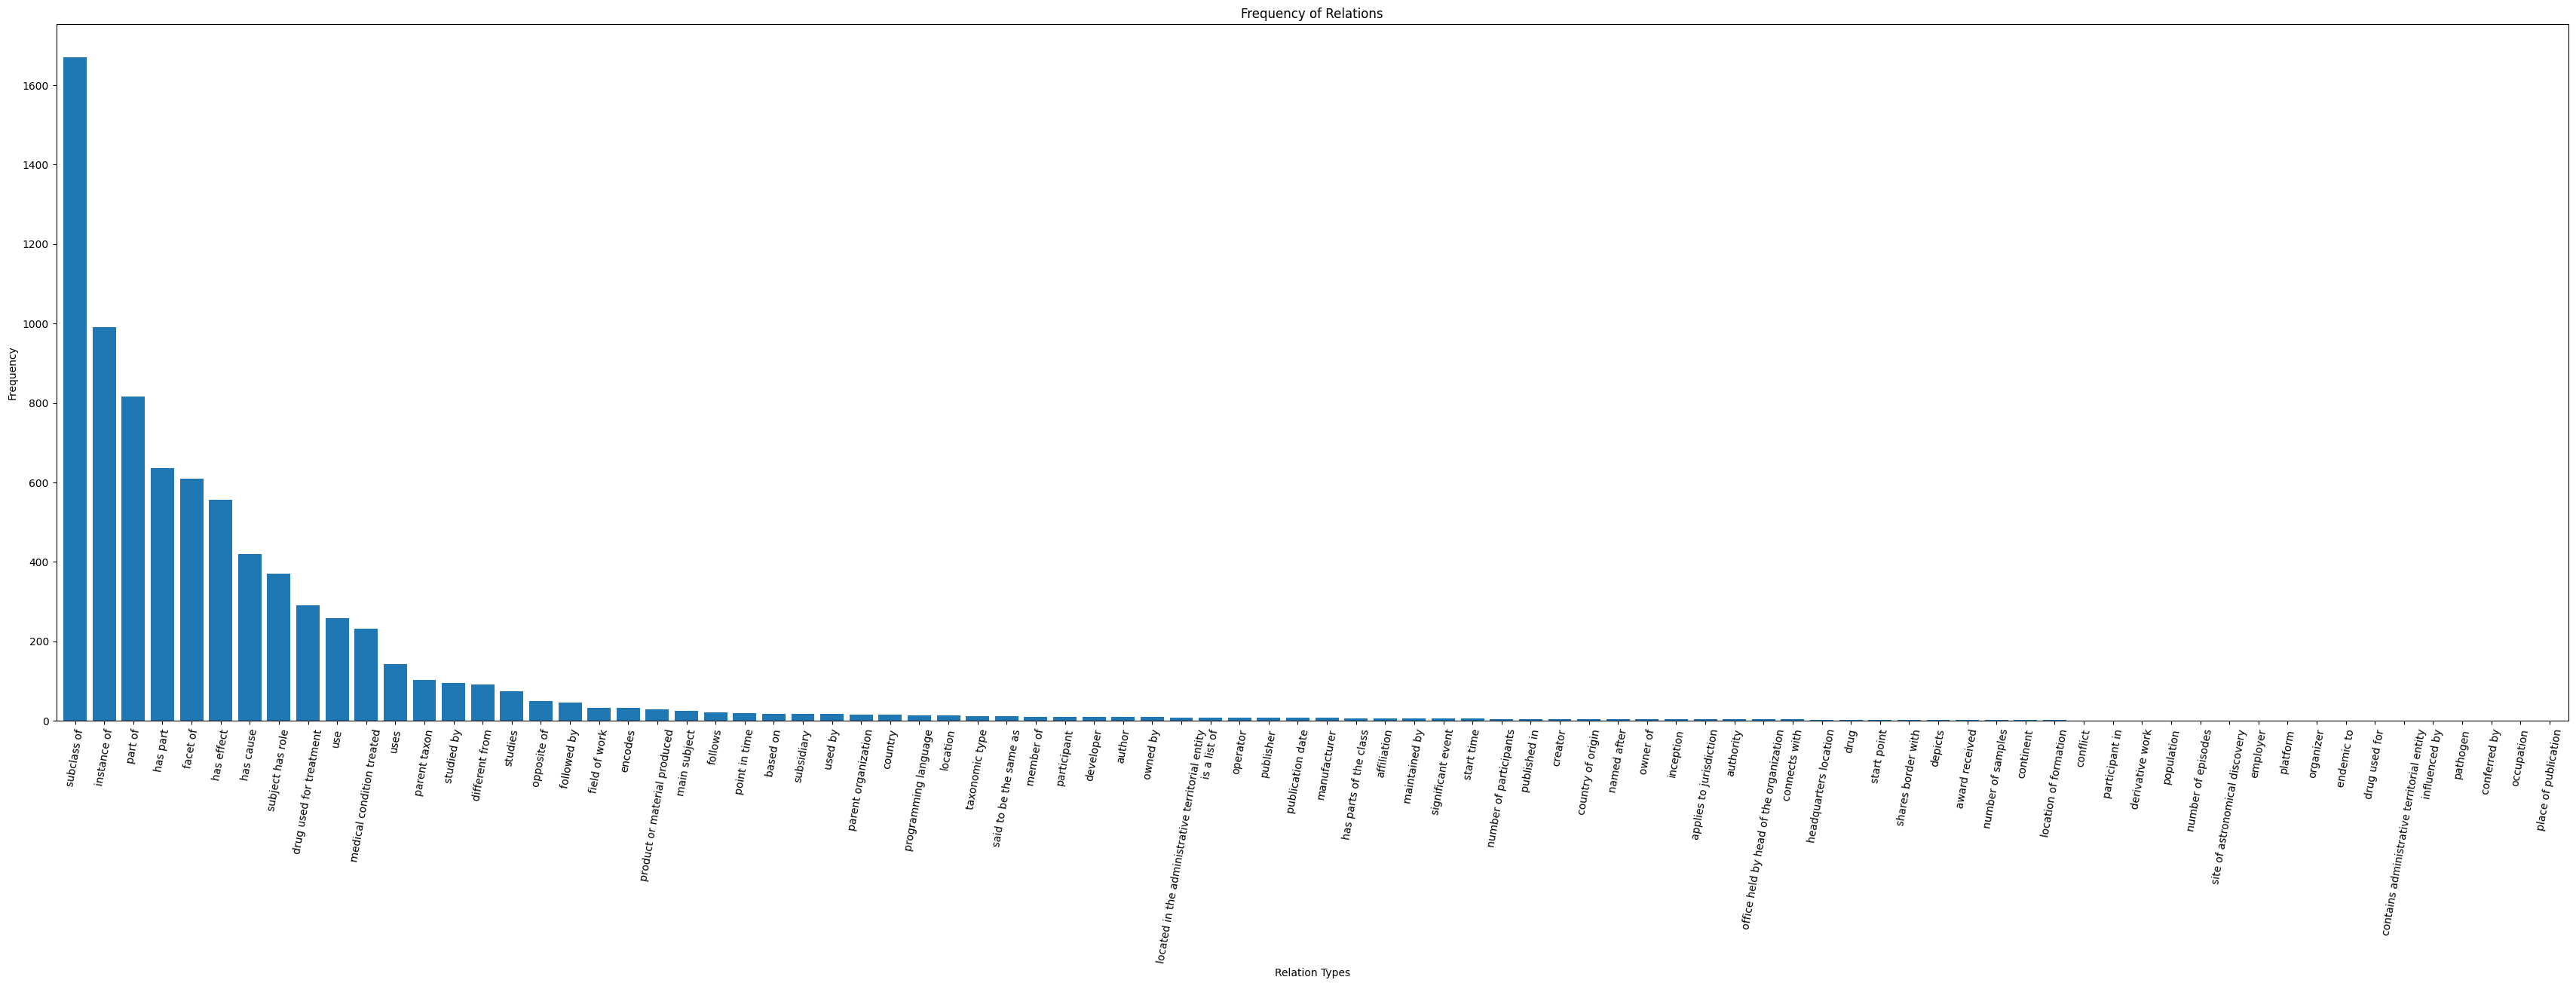

In [ ]:
plot_frequency(unique_triples_all_df, 'relation', 'Relation Types', 'Frequency', 'Frequency of Relations')

## 4. Postprocessing

### 4.1 Missing entities

In [ ]:
# Combine head and tail entities and generate the unique list
entities_list = list(set(unique_triples_all_df['head'].tolist() + unique_triples_all_df['tail'].tolist()))

In [ ]:
len(entities_list)

3109

In [ ]:
with open('2024-06-30_rebel_unique_triples_ents_list_3109.pickle', "wb") as f:
    pickle.dump(entities_list, f)

In [ ]:
entities_list

['',
 'givinostat',
 'bioactivity',
 'betweenness centrality',
 '526',
 'immune system',
 'predictive models',
 'innate antiviral',
 'comparator drug',
 'clinical trial data',
 '3-C proteases',
 'problem of functional links that are possibly not defined as functional links',
 'initial group of 3635 drugs',
 'Heterozygous mutations in BMPR2',
 'Evaluation of the effectiveness',
 'highly mutated and resistant',
 'FDA approved A',
 'SARSCoV-2 viral testing',
 'hereditary',
 'graph convolutional networks',
 'glycyrrhizic acid',
 'viral infections',
 'delta',
 'The Coronavirus',
 'thalidomide',
 'de novo drug development',
 'medication',
 'Foot and Mouth Disease Virus',
 'nucleocapsid protein',
 'flexibility',
 'infecting several people',
 'omicron',
 'RDRP',
 'Val270',
 'Remdesivir Mahase',
 'PolV',
 'membrane protein',
 'double-blind',
 'Covid-19',
 'disease development',
 'severe acute respiratory syndrome CoV SARS‐CoV',
 'coronaviruses',
 'nucleoside analogue',
 'cell entry receptor',
 

The first entity in the list appears to be an empty string.

In [ ]:
# Check for empty strings in 'head' or 'tail'
empty_entities = unique_triples_all_df[(unique_triples_all_df['head'] == '') | (unique_triples_all_df['tail'] == '')]

# Display rows where 'head' or 'tail' is empty
empty_entities

,head,relation,tail
5568,,medical condition treated,chronic myeloid leukemia


In [ ]:
# Check for chronic myeloid leukemia in 'tail'
find_entities = unique_triples_all_df[(unique_triples_all_df['tail'] == 'chronic myeloid leukemia')]

# Display rows where 'tail' is chronic myeloid leukemia
find_entities

,head,relation,tail
1215,bosutinib,medical condition treated,chronic myeloid leukemia
3737,Bosutinib,medical condition treated,chronic myeloid leukemia
5568,,medical condition treated,chronic myeloid leukemia


Looking at KAZU parsed entity output we can identify the sentence this triple was extracted from.

In [ ]:
{'entity_id': 'CHEMBL288441',
   'entity_type': 'drug',
   'entity': 'bosutinib',
   'span_start': 0,
   'span_end': 9,
   'text': 'bosutinib is a treatment for chronic myeloid leukemia by inhibiting the Abelson kinase signaling pathway.',
   'idx': '8822019b7bb34938bf63a4453738c2b8',
   'article_id': 'PMC9556799'},

In [ ]:
# Drop rows where 'head' or 'tail' is empty
unique_triples_all_df_new = unique_triples_all_df[(unique_triples_all_df['head'] != '') & (unique_triples_all_df['tail'] != '')]

# Reindex the DataFrame
unique_triples_all_df_new = unique_triples_all_df_new.reset_index(drop=True)

In [ ]:
len(unique_triples_all_df_new)

7934

In [ ]:
with open('2024-06-30_rebel_unique_triples_all_df_new.pickle', "wb") as f:
    pickle.dump(unique_triples_all_df_new, f)

### 4.2 Deduplication

We will convert the entities to lowercase and drop duplicate triples from the DataFrame.

In [ ]:
# Create copy of DataFrame
unique_triples_all_df_lcase = unique_triples_all_df_new.copy()

In [ ]:
# Convert 'head' and 'tail' columns to lowercase
unique_triples_all_df_lcase['head'] = unique_triples_all_df_lcase['head'].str.lower()
unique_triples_all_df_lcase['tail'] = unique_triples_all_df_lcase['tail'].str.lower()

In [ ]:
unique_triples_all_df_lcase

,head,relation,tail
0,double-blind,use,safety
1,consensus among all approaches,instance of,consensus
2,hydrogen,subclass of,atoms
3,distal airway,part of,lungs
4,sepsis dataset,has part,b
...,...,...,...
7929,ards,has effect,sepsis
7930,network science,studies,artificial intelligence
7931,abiraterone,medical condition treated,covid-19 infection
7932,genetic risk genes,subclass of,gene


In [ ]:
# Drop duplicate rows based on 'head', 'relation', and 'tail' columns
unique_triples_all_dedup_df = unique_triples_all_df_lcase.drop_duplicates(subset=['head', 'relation', 'tail']).reset_index(drop=True)

In [ ]:
len(unique_triples_all_dedup_df)

7782

In [ ]:
unique_triples_all_dedup_df

,head,relation,tail
0,double-blind,use,safety
1,consensus among all approaches,instance of,consensus
2,hydrogen,subclass of,atoms
3,distal airway,part of,lungs
4,sepsis dataset,has part,b
...,...,...,...
7777,ards,has effect,sepsis
7778,network science,studies,artificial intelligence
7779,abiraterone,medical condition treated,covid-19 infection
7780,genetic risk genes,subclass of,gene


In [ ]:
with open('2024-07-10_rebel_unique_triples_all_lcase_dedup_df_7782.pickle', "wb") as f:
    pickle.dump(unique_triples_all_dedup_df, f)

In [ ]:
unique_triples_all_dedup_df.to_csv('2024-07-10_rebel_unique_triples_all_lcase_dedup_df_7782.csv', index=False)

The csv required some manual editing to remove author names, replace some special characters and rectify other errors which would have been difficult to spot and resolve programmatically, although this is not really a scalable solution for high volumes of data.

In [ ]:
unique_triples_all_dedup_edited_df = pd.read_csv('2024-07-11_rebel_unique_triples_all_lcase_dedup_df_7715_edited.csv')

In [ ]:
unique_triples_all_dedup_edited_df

,head,relation,tail
0,double-blind,use,safety
1,consensus among all approaches,instance of,consensus
2,hydrogen,subclass of,atoms
3,distal airway,part of,lungs
4,sepsis dataset,has part,b
...,...,...,...
7710,ards,has effect,sepsis
7711,network science,studies,artificial intelligence
7712,abiraterone,medical condition treated,covid-19 infection
7713,genetic risk genes,subclass of,gene


In [ ]:
# Combine head and tail entities and generate the unique list
entities_list_new = list(set(unique_triples_all_dedup_edited_df['head'].tolist() + unique_triples_all_dedup_edited_df['tail'].tolist()))

In [ ]:
len(entities_list_new)

2914

In [ ]:
with open('2024-07-11_rebel_unique_triples_ents_list_2914.pickle', "wb") as f:
    pickle.dump(entities_list_new, f)

## 5. Llama3-70b

We will use [Meta's Llama3-70b](https://huggingface.co/meta-llama/Meta-Llama-3-70B) model via Hugging Face `transformers` library.




In [ ]:
from huggingface_hub import notebook_login

# This will prompt you to enter your token
notebook_login()

Firstly, we will tokenise the entities so we can plot the distribution of token counts per entity.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-70B")

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### 5.1 Plot token counts

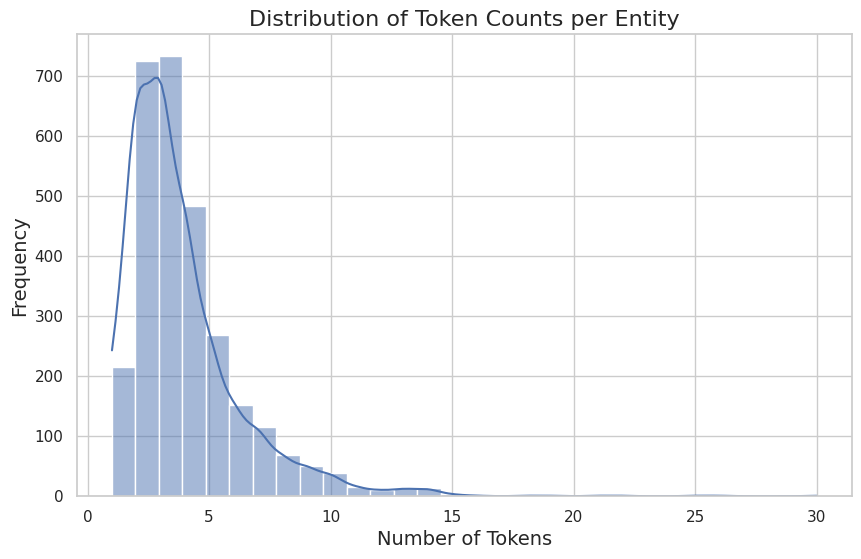

In [ ]:
# Tokenise the text and save the number of tokens
n_tokens = list(map(lambda e: len(tokenizer.tokenize(e)), entities_list_new))

# Set the style of the plot
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(n_tokens, kde=True, bins=30)

# Add title and labels
plt.title('Distribution of Token Counts per Entity', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display the plot
plt.show()

In [ ]:
# Calculate the average number of tokens in an entity
average_tokens = math.ceil(sum(n_tokens) / len(n_tokens))
max_tokens = max(n_tokens)
min_tokens = min(n_tokens)

print(f'Average number of tokens per entity: {average_tokens}')
print(f'Maximum number of tokens per entity: {max_tokens}')
print(f'Minimum number of tokens per entity: {min_tokens}')

Average number of tokens per entity: 4
Maximum number of tokens per entity: 30
Minimum number of tokens per entity: 1


There is a very long entity with 30 tokens.

### 5.2 System message

We will create a system message to define the context and behaviour for the model with step-by-step instructions for identifying and returning canonical and synonymous terms in JSON format.

In [ ]:
system_message = """
As a biomedical annotator, your task involves performing entity disambiguation on an extensive list of entities. You are tasked with identifying canonical entities and their aliases within the given list. Please follow these guidelines:

1. Identify the canonical entity for each group of synonymous terms. The canonical entity should be the most commonly recognized or standard term.
2. List all aliases for each canonical entity, ensuring they are synonyms or variations found within the input list. Avoid including entities as aliases if they could potentially refer to different entities.
3. Ensure the output is formatted as valid JSON, containing only those entities with identified aliases. Entities lacking aliases should not appear in the output.

Please adhere strictly to the following output format:
{
  "entities": [
    {
      "canonical": "<canonical entity>",
      "aliases": ["<alias 1>", "<alias 2>", "..."]
    },
   ...
  ]
}

Remember, the aliases must be actual entities present in the input list. Do not introduce new entities or leave empty entries for entities without aliases. Focus solely on providing a clean, structured JSON output without any additional text or formatting.

For example:
1. The canonical entity 'covid-19' has aliases such as 'coronavirus disease-2019', '2019 coronavirus', 'covid-19 infection', 'covid-19 disease', 'covid-19 virus'. Do not include 'coronavirus' as it might refer to other coronaviruses.
2. The canonical entity 'sars-cov-2' has aliases such as 'severe acute respiratory syndrome coronavirus-2', 'sars-cov2', 'sars cov-2', 'sarscov-2'. Do not include 'sars‐cov' or 'sars-cov-1' as they refer to different viruses.

Example input format:
entities_list = "covid-19, coronavirus disease-2019, 2019 coronavirus, covid-19 infection, covid-19 disease, covid-19 virus, coronavirus, sars-cov-2, severe acute respiratory syndrome coronavirus-2, sars-cov2, sars cov-2, sarscov-2, sars‐cov, sars-cov-1..."

Example output format (for a subset of the input):
{"entities": [{"canonical": "covid-19","aliases": ["coronavirus disease-2019", "2019 coronavirus", "covid-19 infection", "covid-19 disease", "covid-19 virus"]},
{"canonical": "sars-cov-2", "aliases": ["severe acute respiratory syndrome coronavirus-2", "sars-cov2", "sars cov-2", "sarscov-2"]},
{"canonical": "sars‐cov", "aliases": ["sars-cov-1"]}]}

IMPORTANT:
Output should be valid JSON only. Do not add any additional text, explanations, or formatting such as markdown or code blocks.
Output should include all entities with aliases, even those with only one alias.
"""

In [ ]:
# length of the system message in tokens
len(tokenizer.tokenize(system_message))

629

### 5.3 Split entities list into chunks

In [ ]:
def split_and_join_entities(entities_list, chunk_size):
    """
    Split the entities list into chunks of a specified size and join each chunk into a string.

    Args:
    - entities_list (list): List of entities to split.
    - chunk_size (int): Number of entities per chunk.

    Returns:
    - list: A list of joined entity strings, each containing up to chunk_size entities.
    """
    chunks = [entities_list[i:i + chunk_size] for i in range(0, len(entities_list), chunk_size)]
    joined_chunks = [', '.join(chunk) for chunk in chunks]
    return joined_chunks

In [ ]:
chunk_size = 1000

joined_chunks = split_and_join_entities(entities_list_new, chunk_size)

In [ ]:
len(joined_chunks)

3

In [ ]:
joined_chunks

["nsp7, samples, sars-cov-2 pathogenicity, phe314, remdesivir-resistant infection, a worldwide health emergency, human norovirus hnv, emergent, ebola virus remdesivir, ai methods, biological regulation genes, sonic hedgehog shh, coordination, immune illnesses, immunological, severe mutations, ucsf chimera, general condition, another network proximity-based drug repurposing study, sdf, covid-19 cases recently, grasp, viral families, deep docking dd platform, apo form, data-driven, accelerated recovery, pathophysiological, allergies, anti-novel 2019 coronavirus, graph kernels, 6m71/sofosbuvir, geo, integrative, nucleotide-binding, already available on the market, crvs, mean, human protein interactions, ps, e, ponatinib, 10th june, 2022, dasabuvir, casein kinase 2, polymerase, vero, integrative drug repositioning analysis, amprenavir, biological process bp, proximity distance, clathrin, nf-b, influenza, ligand-bound complexes, protein's stability, pmf, platelet activation, irf1, met6818, 

## 6. Groq

[Groq](https://groq.com/)'s Language Processing Unit (LPU) Inference Engine is designed for fast AI inference and can be accessed via the [GroqCloud](https://console.groq.com/playground) API.

We will prompt supported models to normalise entities by identifying the canonical entity for each group of synonymous terms and output as JSON.

First we will load the API key and initialise the Groq client.

In [ ]:
with open("api_keys.json") as f:
    data = json.load(f)

In [ ]:
groq_api_key = data['keys']["GROQ_API_KEY"]

In [ ]:
from groq import Groq

In [ ]:
# initialise Groq client
client = Groq(api_key=groq_api_key)

### 6.1 Llama3-70b

We will use Llama3-70b (`llama3-70b-8192` with context window of 8192 tokens), one of the [supported models](https://console.groq.com/docs/models), although more have since been added with longer context windows.

The request-response format of OpenAI is now industry standard and a lot of open source LLMs follow the same format. The Groq Chat Completions API processes a series of messages and generates output responses.

We will define some helper functions to interact with the chat interface.

In [ ]:
# Function to send disambiguation request
def disambiguate(prompt):
    """Send one request and retrieve model's generation."""
    chat_completion = client.chat.completions.create(
        messages=prompt,
        model='llama3-70b-8192',
        temperature=0,
        max_tokens=8192,
        top_p=1,
        stop=None,
        stream=False,
        seed=42
    )
    return chat_completion.choices[0].message.content

In [ ]:
# Function to process entities in batches
def process_entities(chunks, system_message):
    results = []
    for chunk in tqdm(chunks):
        prompt = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": chunk}
        ]
        result = disambiguate(prompt)
        results.append(result)
        time.sleep(10)  # Wait between batches to comply with rate limits
    return results

In [ ]:
llama3_70b_results = process_entities(joined_chunks, system_message)
with open('2024-07-11_groq_llama-3-70b_entity_dedup_chunks.pickle', 'wb') as f:
  pickle.dump(llama3_70b_results, f)

100%|██████████| 3/3 [02:08<00:00, 42.90s/it]


In [ ]:
llama3_70b_results

['Here is the output in the required JSON format:\n\n```\n{\n  "entities": [\n    {\n      "canonical": "sars-cov-2",\n      "aliases": ["severe acute respiratory syndrome coronavirus-2", "sarscov-2", "sars-cov2", "sars cov-2", "sarscov2"]\n    },\n    {\n      "canonical": "covid-19",\n      "aliases": ["coronavirus disease-2019", "2019 coronavirus", "covid-19 infection", "covid-19 disease", "covid-19 virus", "coronavirus disease 2019"]\n    },\n    {\n      "canonical": "sars-cov",\n      "aliases": ["severe acute respiratory syndrome coronavirus", "sars coronavirus", "sars-cov-1"]\n    },\n    {\n      "canonical": "ebola virus",\n      "aliases": ["ebola"]\n    },\n    {\n      "canonical": "human norovirus",\n      "aliases": ["hnv", "norovirus hnv"]\n    },\n    {\n      "canonical": "influenza",\n      "aliases": ["hcov", "human coronaviruses hcov"]\n    },\n    {\n      "canonical": "middle east respiratory syndrome coronavirus",\n      "aliases": ["mers-cov"]\n    },\n    {\n 

Despite the explicit guidance in the system message, the model has not adhered to the instruction not to add any additional text or explanation. The output will require further postprocessing to extract valid JSON from the response.



In [ ]:
def extract_json_from_response(response):
    """
    Extract and clean the JSON content from a response string.
    Removes spaces and newlines from the JSON content.
    """
    # Find the JSON part using regex to match the JSON structure
    json_match = re.search(r'\{.*\}', response, re.DOTALL)

    if json_match:
        json_content = json_match.group(0)
        try:
            # Load the JSON content to ensure it is valid
            data = json.loads(json_content)
            # Convert back to string to remove spaces and newlines
            compact_json = json.dumps(data, separators=(',', ':'))
            return compact_json
        except json.JSONDecodeError:
            print("Invalid JSON response:", json_content)
            return None
    else:
        print("No JSON content found in the response.")
        return None


Llama3-70b also appears to have hallucinated entities containing uppercase letters despite the input data being converted to lowercase.
We will lowercase, merge and deduplicate canonical and synonymous terms from the cleaned JSON.

In [ ]:
def merge_and_deduplicate_results(results):
    """Merge JSON results and remove duplicate canonical and alias entries."""
    aggregated_entities = {}

    def normalise_string(s):
        return s.lower().strip()

    for response in results:
        clean_json = extract_json_from_response(response)
        if clean_json:
            try:
                data = json.loads(clean_json)
                if "entities" in data:
                    for entity in data["entities"]:
                        canonical = normalise_string(entity["canonical"])
                        aliases = set(normalise_string(alias) for alias in entity["aliases"])

                        if canonical in aggregated_entities:
                            aggregated_entities[canonical].update(aliases)
                        else:
                            aggregated_entities[canonical] = aliases
            except json.JSONDecodeError:
                print("Invalid JSON response:", clean_json)

    # Convert the aggregated entities back to the required JSON structure
    merged_entities = [{"canonical": canonical, "aliases": sorted(list(aliases))} for canonical, aliases in aggregated_entities.items()]
    return {"entities": merged_entities}

In [ ]:
final_llama3_70b_result = merge_and_deduplicate_results(llama3_70b_results)
with open('2024-07-12_groq_llama-3-70b_entity_dedup_merged.pickle', 'wb') as f:
  pickle.dump(final_llama3_70b_result, f)

In [ ]:
# cleaned JSON output
final_llama3_70b_result

{'entities': [{'canonical': 'sars-cov-2',
   'aliases': ['sars cov-2',
    'sars-cov2',
    'sarscov-2',
    'sarscov2',
    'severe acute respiratory syndrome coronavirus-2']},
  {'canonical': 'covid-19',
   'aliases': ['2019 coronavirus',
    'coronavirus disease 2019',
    'coronavirus disease-2019',
    'covid-19 disease',
    'covid-19 infection',
    'covid-19 virus']},
  {'canonical': 'sars-cov',
   'aliases': ['sars coronavirus',
    'sars-cov-1',
    'severe acute respiratory syndrome coronavirus']},
  {'canonical': 'ebola virus', 'aliases': ['ebola']},
  {'canonical': 'human norovirus', 'aliases': ['hnv', 'norovirus hnv']},
  {'canonical': 'influenza', 'aliases': ['hcov', 'human coronaviruses hcov']},
  {'canonical': 'middle east respiratory syndrome coronavirus',
   'aliases': ['mers-cov']},
  {'canonical': 'hepatitis c virus',
   'aliases': ['hcv', 'hepatitis c virus hcv ns3/4a protease inhibitor']},
  {'canonical': 'human immunodeficiency virus',
   'aliases': ['hiv', 'hum

In [ ]:
with open('2024-07-12_llama3-70b-canonicals.json', 'w') as f:
  json.dump(final_llama3_70b_result, f, indent=4)

There are still some inconsistencies such as 'sars-cov-2' and 'covid-19' appearing both as canonicals and aliases.

### 6.2 Llama3-8b

We will repeat the process using Llama3-8b (`llama3-8b-8192`), another supported model.

In [ ]:
# Function to send disambiguation request
def disambiguate(prompt):
    """Send one request and retrieve model's generation."""
    chat_completion = client.chat.completions.create(
        messages=prompt,
        model='llama3-8b-8192',
        temperature=0,
        max_tokens=8192,
        top_p=1,
        stop=None,
        stream=False,
        seed=42
    )
    return chat_completion.choices[0].message.content

In [ ]:
# Function to process entities in batches
def process_entities(chunks, system_message):
    results = []
    for chunk in tqdm(chunks):
        prompt = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": chunk}
        ]
        result = disambiguate(prompt)
        results.append(result)
        time.sleep(10)  # Wait between batches to comply with rate limits
    return results

In [ ]:
llama3_8b_results = process_entities(joined_chunks, system_message)
with open('2024-07-12_groq_llama-3-8b_entity_dedup_merged.pickle', 'wb') as f:
  pickle.dump(llama3_8b_results, f)

100%|██████████| 3/3 [00:36<00:00, 12.22s/it]


In [ ]:
llama3_8b_results

['Here is the output in the required format:\n\n```\n{\n  "entities": [\n    {\n      "canonical": "sars-cov-2",\n      "aliases": [\n        "severe acute respiratory syndrome coronavirus-2",\n        "sars-cov2",\n        "sars cov-2",\n        "sarscov-2",\n        "sars-cov",\n        "covid-19",\n        "coronavirus disease-2019",\n        "novel coronavirus cov",\n        "2019 coronavirus",\n        "covid-19 virus",\n        "coronavirus disease 2019",\n        "covid-19\'s",\n        "sars-cov-2 pathogenicity",\n        "sars-cov-2 infection",\n        "sars-cov-2 variant",\n        "sars-cov-2 a",\n        "sars-cov-2 variant gamma",\n        "sars-cov-2 illness",\n        "sars-cov-2 receptor",\n        "sars-cov-2 replication",\n        "sars-cov-2 spike",\n        "sars-cov-2 variant alpha",\n        "sars-cov-2 variant beta",\n        "sars-cov-2 variant delta",\n        "sars-cov-2 variant mu",\n        "sars-cov-2 variant omicron"\n      ]\n    },\n    {\n      "canoni

We will lowercase, merge and deduplicate canonical and synonymous terms from the cleaned JSON.

In [ ]:
final_llama3_8b_result = merge_and_deduplicate_results(llama3_8b_results)
with open('2024-07-12_groq_llama-3-8b_entity_dedup_merged.pickle', 'wb') as f:
  pickle.dump(final_llama3_8b_result, f)

In [ ]:
# cleaned JSON output
final_llama3_8b_result

{'entities': [{'canonical': 'sars-cov-2',
   'aliases': ['2019 coronavirus',
    'coronavirus disease 2019',
    'coronavirus disease-2019',
    'covid-19',
    'covid-19 virus',
    "covid-19's",
    'novel coronavirus cov',
    'sars cov-2',
    'sars-cov',
    'sars-cov-2 a',
    'sars-cov-2 illness',
    'sars-cov-2 infection',
    'sars-cov-2 pathogenicity',
    'sars-cov-2 receptor',
    'sars-cov-2 replication',
    'sars-cov-2 spike',
    'sars-cov-2 variant',
    'sars-cov-2 variant alpha',
    'sars-cov-2 variant beta',
    'sars-cov-2 variant delta',
    'sars-cov-2 variant gamma',
    'sars-cov-2 variant mu',
    'sars-cov-2 variant omicron',
    'sars-cov2',
    'sarscov-2',
    'severe acute respiratory syndrome coronavirus-2']},
  {'canonical': 'covid-19',
   'aliases': ['2019 coronavirus',
    'coronavirus disease 2019',
    'coronavirus disease-2019',
    'covid-19 cases recently',
    'covid-19 clinical trial',
    'covid-19 cytokine storms',
    'covid-19 disease',
 

In [ ]:
with open('2024-07-12_llama3-8b-canonicals.json', 'w') as f:
  json.dump(final_llama3_8b_result, f, indent=4)

## 7. Postprocessing






### 7.1 Merge and deduplicate JSON

We will merge and deduplicate the two JSON files for Llama3-70b and Llama3-8b.

In [ ]:
def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r') as file:
        return json.load(file)

def save_json(data, file_path):
    """Save JSON data to a file."""
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

In [ ]:
def merge_and_deduplicate_entities(json1, json2):
    """Merge and deduplicate entities from two JSON data sets."""
    merged_entities = {}

    def process_entities(entities):
        for entity in entities:
            canonical = entity["canonical"]
            aliases = set(entity["aliases"])

            if canonical in merged_entities:
                merged_entities[canonical].update(aliases)
            else:
                merged_entities[canonical] = aliases

    process_entities(json1["entities"])
    process_entities(json2["entities"])

    # Convert the merged entities back to the required JSON structure
    merged_json = {"entities": [{"canonical": canonical, "aliases": list(aliases)} for canonical, aliases in merged_entities.items()]}
    return merged_json

In [ ]:
# Load the JSON data from both files
json1 = load_json("2024-07-12_llama3-70b-canonicals.json")
json2 = load_json("2024-07-12_llama3-8b-canonicals.json")

In [ ]:
# Merge and deduplicate the JSON data
merged_json = merge_and_deduplicate_entities(json1, json2)

In [ ]:
merged_json

{'entities': [{'canonical': 'sars-cov-2',
   'aliases': ['sars-cov-2 a',
    'sars-cov2',
    'sars-cov-2 illness',
    'sars-cov-2 variant alpha',
    'novel coronavirus cov',
    'sarscov2',
    '2019 coronavirus',
    'coronavirus disease 2019',
    'sars-cov-2 variant',
    'sars-cov-2 variant beta',
    'sars-cov-2 variant delta',
    'sars-cov-2 pathogenicity',
    'covid-19 virus',
    'sars-cov',
    'covid-19',
    'sars-cov-2 variant mu',
    'sarscov-2',
    'sars-cov-2 variant gamma',
    'sars-cov-2 infection',
    'sars-cov-2 replication',
    "covid-19's",
    'sars-cov-2 spike',
    'sars-cov-2 variant omicron',
    'coronavirus disease-2019',
    'sars-cov-2 receptor',
    'sars cov-2',
    'severe acute respiratory syndrome coronavirus-2']},
  {'canonical': 'covid-19',
   'aliases': ['covid-19 infection',
    'covid-19 disease',
    'covid-19 therapy',
    'covid-19 recovery rate',
    'covid-19 pandemic',
    'covid-19 spread',
    'covid-19 prevention',
    'covid-1

In [ ]:
# Save the merged and deduplicated JSON data to a new file
save_json(merged_json, '2024-07-12_merged_llama3_canonicals.json')

After merging and deduplicating output from the two Llama3 models there are instances of the same alias appearing for different canonicals such as "covid-19 virus" appearing as an alias for both "sars-cov-2" and "covid-19", and "covid-19" itself appearing as a canonical. There are also canonicals with empty alias lists.  The file will be manually updated before proceeding to replace aliases with canonicals in the triples data.

In [ ]:
# load manually updated merged JSON file
merged_json_updated = load_json('2024-07-13_merged_llama3_canonicals_updated.json')

In [ ]:
merged_json_updated

{'entities': [{'canonical': 'sars-cov-2',
   'aliases': ['sars-cov-2 a',
    'sars-',
    'sars-cov2',
    'sars-cov-2 illness',
    'sarscov2',
    'sars-cov-2 variant',
    'sars-cov-2 pathogenicity',
    'sarscov-2',
    'sars-cov-2 infection',
    'sars cov-2',
    'the sars-cov-2',
    'acute respiratory syndrome coronavirus 2',
    'severe acute respiratory syndrome coronavirus-2',
    'severe acute respiratory syndrome coronavirus 2',
    'the severe acute respiratory syndrome coronavirus-2 sars-cov-2',
    'the severe acute respiratory syndrome coronavirus-2',
    'severe acute respiratory syndrome coronavirus 2 sars-cov-2',
    'sars-cov-2/coronavirus',
    'sars-cov-2 covid-19',
    'sars-cov-2 virus',
    'sars-cov-2 outbreak']},
  {'canonical': 'covid-19',
   'aliases': ['covid-19 infection',
    'covid-19 infections',
    'covid-19 disease',
    'covid-19 disease severity',
    'covid-19 spread',
    '2019 coronavirus',
    '2019 coronavirus covid-19',
    'coronavirus dis

### 7.2 Replace aliases with canonicals

We will first create a mapping between each alias and its canonical.

In [ ]:
# Create a mapping from aliases to canonical entities
def create_alias_to_canonical_mapping(json_output):
    data = json_output
    alias_to_canonical = {}
    for entity in data["entities"]:
        canonical = entity["canonical"]
        aliases = entity["aliases"]
        for alias in aliases:
            alias_to_canonical[alias] = canonical
    return alias_to_canonical

In [ ]:
alias_to_canonical = create_alias_to_canonical_mapping(merged_json_updated)

In [ ]:
with open('2024-07-13_alias_to_canonical.pickle', "wb") as f:
    pickle.dump(alias_to_canonical, f)

In [ ]:
alias_to_canonical

{'sars-cov-2 a': 'sars-cov-2',
 'sars-': 'sars-cov-2',
 'sars-cov2': 'sars-cov-2',
 'sars-cov-2 illness': 'sars-cov-2',
 'sarscov2': 'sars-cov-2',
 'sars-cov-2 variant': 'sars-cov-2',
 'sars-cov-2 pathogenicity': 'sars-cov-2',
 'sarscov-2': 'sars-cov-2',
 'sars-cov-2 infection': 'sars-cov-2',
 'sars cov-2': 'sars-cov-2',
 'the sars-cov-2': 'sars-cov-2',
 'acute respiratory syndrome coronavirus 2': 'sars-cov-2',
 'severe acute respiratory syndrome coronavirus-2': 'sars-cov-2',
 'severe acute respiratory syndrome coronavirus 2': 'sars-cov-2',
 'the severe acute respiratory syndrome coronavirus-2 sars-cov-2': 'sars-cov-2',
 'the severe acute respiratory syndrome coronavirus-2': 'sars-cov-2',
 'severe acute respiratory syndrome coronavirus 2 sars-cov-2': 'sars-cov-2',
 'sars-cov-2/coronavirus': 'sars-cov-2',
 'sars-cov-2 covid-19': 'sars-cov-2',
 'sars-cov-2 virus': 'sars-cov-2',
 'sars-cov-2 outbreak': 'sars-cov-2',
 'covid-19 infection': 'covid-19',
 'covid-19 infections': 'covid-19',
 '

Next we will define a function to replace aliases with canonicals for the head and tail entities in our DataFrame of triples extracted by REBEL.

In [ ]:
# Function to replace aliases
def replace_aliases_in_dataframe(df, alias_to_canonical):
    df_replaced = df.copy()
    df_replaced['head'] = df_replaced['head'].apply(lambda x: alias_to_canonical.get(x, x))
    df_replaced['tail'] = df_replaced['tail'].apply(lambda x: alias_to_canonical.get(x, x))
    return df_replaced

In [ ]:
# load REBEL triples
unique_triples_all_dedup_edited_df = pd.read_csv('2024-07-11_rebel_unique_triples_all_lcase_dedup_df_7715_edited.csv')

In [ ]:
# replace aliases with canonicals
unique_triples_canonical_df = replace_aliases_in_dataframe(unique_triples_all_dedup_edited_df, alias_to_canonical)

In [ ]:
with open('2024-07-13_rebel_unique_triples_canonical_df.pickle', "wb") as f:
    pickle.dump(unique_triples_canonical_df, f)

In [ ]:
unique_triples_canonical_df.tail()

,head,relation,tail
7710,ards,has effect,sepsis
7711,network science,studies,ai
7712,abiraterone,medical condition treated,covid-19
7713,genetic risk genes,subclass of,gene
7714,mm-gbsa,facet of,molecular dynamic


Compare with DataFrame prior to lowercasing entities and replacing aliases with canonicals.

In [ ]:
unique_triples_all_df_new.tail()

,head,relation,tail
7929,ARDS,has effect,sepsis
7930,network science,studies,artificial intelligence
7931,abiraterone,medical condition treated,COVID-19 infection
7932,genetic risk genes,subclass of,gene
7933,MM-GBSA,facet of,molecular dynamic MD


### 7.3 Deduplication

We will drop duplicate rows and rows where the head and tail entity are the same as these are unlikely to be valid triples.



In [ ]:
# Drop duplicate rows based on 'head', 'relation', and 'tail' columns
unique_triples_canonical_dedup_df = unique_triples_canonical_df.drop_duplicates(subset=['head', 'relation', 'tail']).reset_index(drop=True)

In [ ]:
len(unique_triples_canonical_dedup_df)

7227

In [ ]:
# Remove rows where the 'head' value is the same as the 'tail' value
unique_triples_canonical_dedup_cleaned_df = unique_triples_canonical_dedup_df[unique_triples_canonical_dedup_df['head'] != unique_triples_canonical_dedup_df['tail']].reset_index(drop=True)

In [ ]:
len(unique_triples_canonical_dedup_cleaned_df)

7149

In [ ]:
with open('2024-07-13_rebel_unique_triples_canonical_dedup_cleaned_df_7149.pickle', "wb") as f:
    pickle.dump(unique_triples_canonical_dedup_cleaned_df, f)

In [ ]:
unique_triples_canonical_dedup_cleaned_df.to_csv('2024-07-13_rebel_unique_triples_canonical_dedup_cleaned_df_7149.csv', index=False)

### 7.4 Entity and Relation counts

In [ ]:
# unique head entities
len(unique_triples_canonical_dedup_cleaned_df['head'].unique())

1980

In [ ]:
# frequency of head entities
Counter(unique_triples_canonical_dedup_cleaned_df['head']).most_common()

[('covid-19', 546),
 ('sars-cov-2', 262),
 ('rna-dependent rna polymerase', 92),
 ('remdesivir', 84),
 ('molnupiravir', 71),
 ('coronavirus', 50),
 ('deep learning', 43),
 ('covid-19 pandemic', 40),
 ('cytokine storm', 40),
 ('nsp12', 32),
 ('molecular docking', 32),
 ('ards', 31),
 ('ace2', 30),
 ('chloroquine', 29),
 ('drug repositioning', 29),
 ('sars-cov', 28),
 ('machine learning', 28),
 ('sofosbuvir', 28),
 ('spike protein', 27),
 ('drug discovery', 27),
 ('virus', 26),
 ('dasabuvir', 24),
 ('eidd-1931', 24),
 ('nsp', 24),
 ('protein', 23),
 ('hydroxychloroquine', 23),
 ('z-score', 23),
 ('ritonavir', 22),
 ('mers-cov', 22),
 ('gwas', 22),
 ('ligand', 21),
 ('genes', 21),
 ('genome', 21),
 ('lopinavir', 20),
 ('rdrp domain', 20),
 ('cetilistat', 20),
 ('bexarotene', 20),
 ('drug repurposing', 19),
 ('bioinformatics', 19),
 ('phase 3', 19),
 ('sepsis', 19),
 ('chlorpromazine', 18),
 ('network medicine', 18),
 ('spike glycoprotein', 18),
 ('hiv', 17),
 ('precision medicine', 17),
 

In [ ]:
# unique tail entities
len(unique_triples_canonical_dedup_cleaned_df['tail'].unique())

1873

In [ ]:
# frequency of tail entities
Counter(unique_triples_canonical_dedup_cleaned_df['tail']).most_common()

[('covid-19', 252),
 ('sars-cov-2', 221),
 ('protein', 119),
 ('machine learning', 94),
 ('drug', 68),
 ('drugs', 64),
 ('amino acids', 59),
 ('gene', 55),
 ('proteins', 53),
 ('deep learning', 51),
 ('virus', 51),
 ('antiviral', 45),
 ('coronavirus', 43),
 ('drug repurposing', 38),
 ('nsp', 36),
 ('molnupiravir', 35),
 ('ligand', 32),
 ('drug repositioning', 30),
 ('bioinformatics', 29),
 ('who', 29),
 ('network science', 28),
 ('drug discovery', 27),
 ('protease', 27),
 ('sirs', 27),
 ('sars-cov 2', 26),
 ('genes', 26),
 ('rna', 25),
 ('remdesivir', 25),
 ('sars-cov', 25),
 ('spike protein', 24),
 ('covid-19 pandemic', 24),
 ('cancer', 24),
 ('cytokine storm', 23),
 ('amino acid', 23),
 ('rna-dependent rna polymerase', 22),
 ('clinical trial', 22),
 ('mutations', 22),
 ('fda', 22),
 ('sepsis', 22),
 ('receptor', 21),
 ('compound', 21),
 ('z-score', 21),
 ('gene expression', 21),
 ('ai', 20),
 ('in vitro', 20),
 ('nsp12', 20),
 ('genome', 20),
 ('network medicine', 19),
 ('fda-approve

In [ ]:
# unique relations
len(unique_triples_canonical_dedup_cleaned_df['relation'].unique())

82

In [ ]:
# frequency of relations
Counter(unique_triples_canonical_dedup_cleaned_df['relation']).most_common()

[('subclass of', 1543),
 ('instance of', 919),
 ('part of', 763),
 ('has part', 595),
 ('facet of', 576),
 ('has effect', 448),
 ('subject has role', 352),
 ('has cause', 310),
 ('use', 249),
 ('drug used for treatment', 240),
 ('medical condition treated', 194),
 ('uses', 140),
 ('studied by', 90),
 ('different from', 79),
 ('parent taxon', 76),
 ('studies', 74),
 ('opposite of', 47),
 ('followed by', 46),
 ('encodes', 31),
 ('product or material produced', 26),
 ('main subject', 24),
 ('field of work', 23),
 ('follows', 21),
 ('based on', 17),
 ('used by', 17),
 ('point in time', 16),
 ('country', 15),
 ('subsidiary', 12),
 ('parent organization', 12),
 ('location', 12),
 ('participant', 9),
 ('owned by', 8),
 ('programming language', 8),
 ('developer', 8),
 ('is a list of', 8),
 ('author', 7),
 ('operator', 7),
 ('taxonomic type', 7),
 ('manufacturer', 7),
 ('located in the administrative territorial entity', 6),
 ('has parts of the class', 6),
 ('publication date', 6),
 ('start tim

#### 7.4.1 Plot frequency of Relations

In [ ]:
def plot_frequency(df, column_name, x_label, y_label, title, bar_width=0.8):
    """
    Plot the frequency of values in the specified column of the given DataFrame.

    Args:
    df (DataFrame): DataFrame containing the entities.
    column_name (str): Name of the column to plot the frequency of values from.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    title (str): Title of the plot.
    bar_width (float): Width of the bars. Defaults to 0.8.

    Returns:
    None (displays the plot)
    """

    # Count the frequency of each entity or relation in the specified column
    val_counts = df[column_name].value_counts()

    # Plotting
    plt.figure(figsize=(max(10, len(val_counts) * 0.5), 12))
    val_counts.plot(kind='bar', width=bar_width)

    # Adding labels and title
    plt.xticks(rotation=80)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()

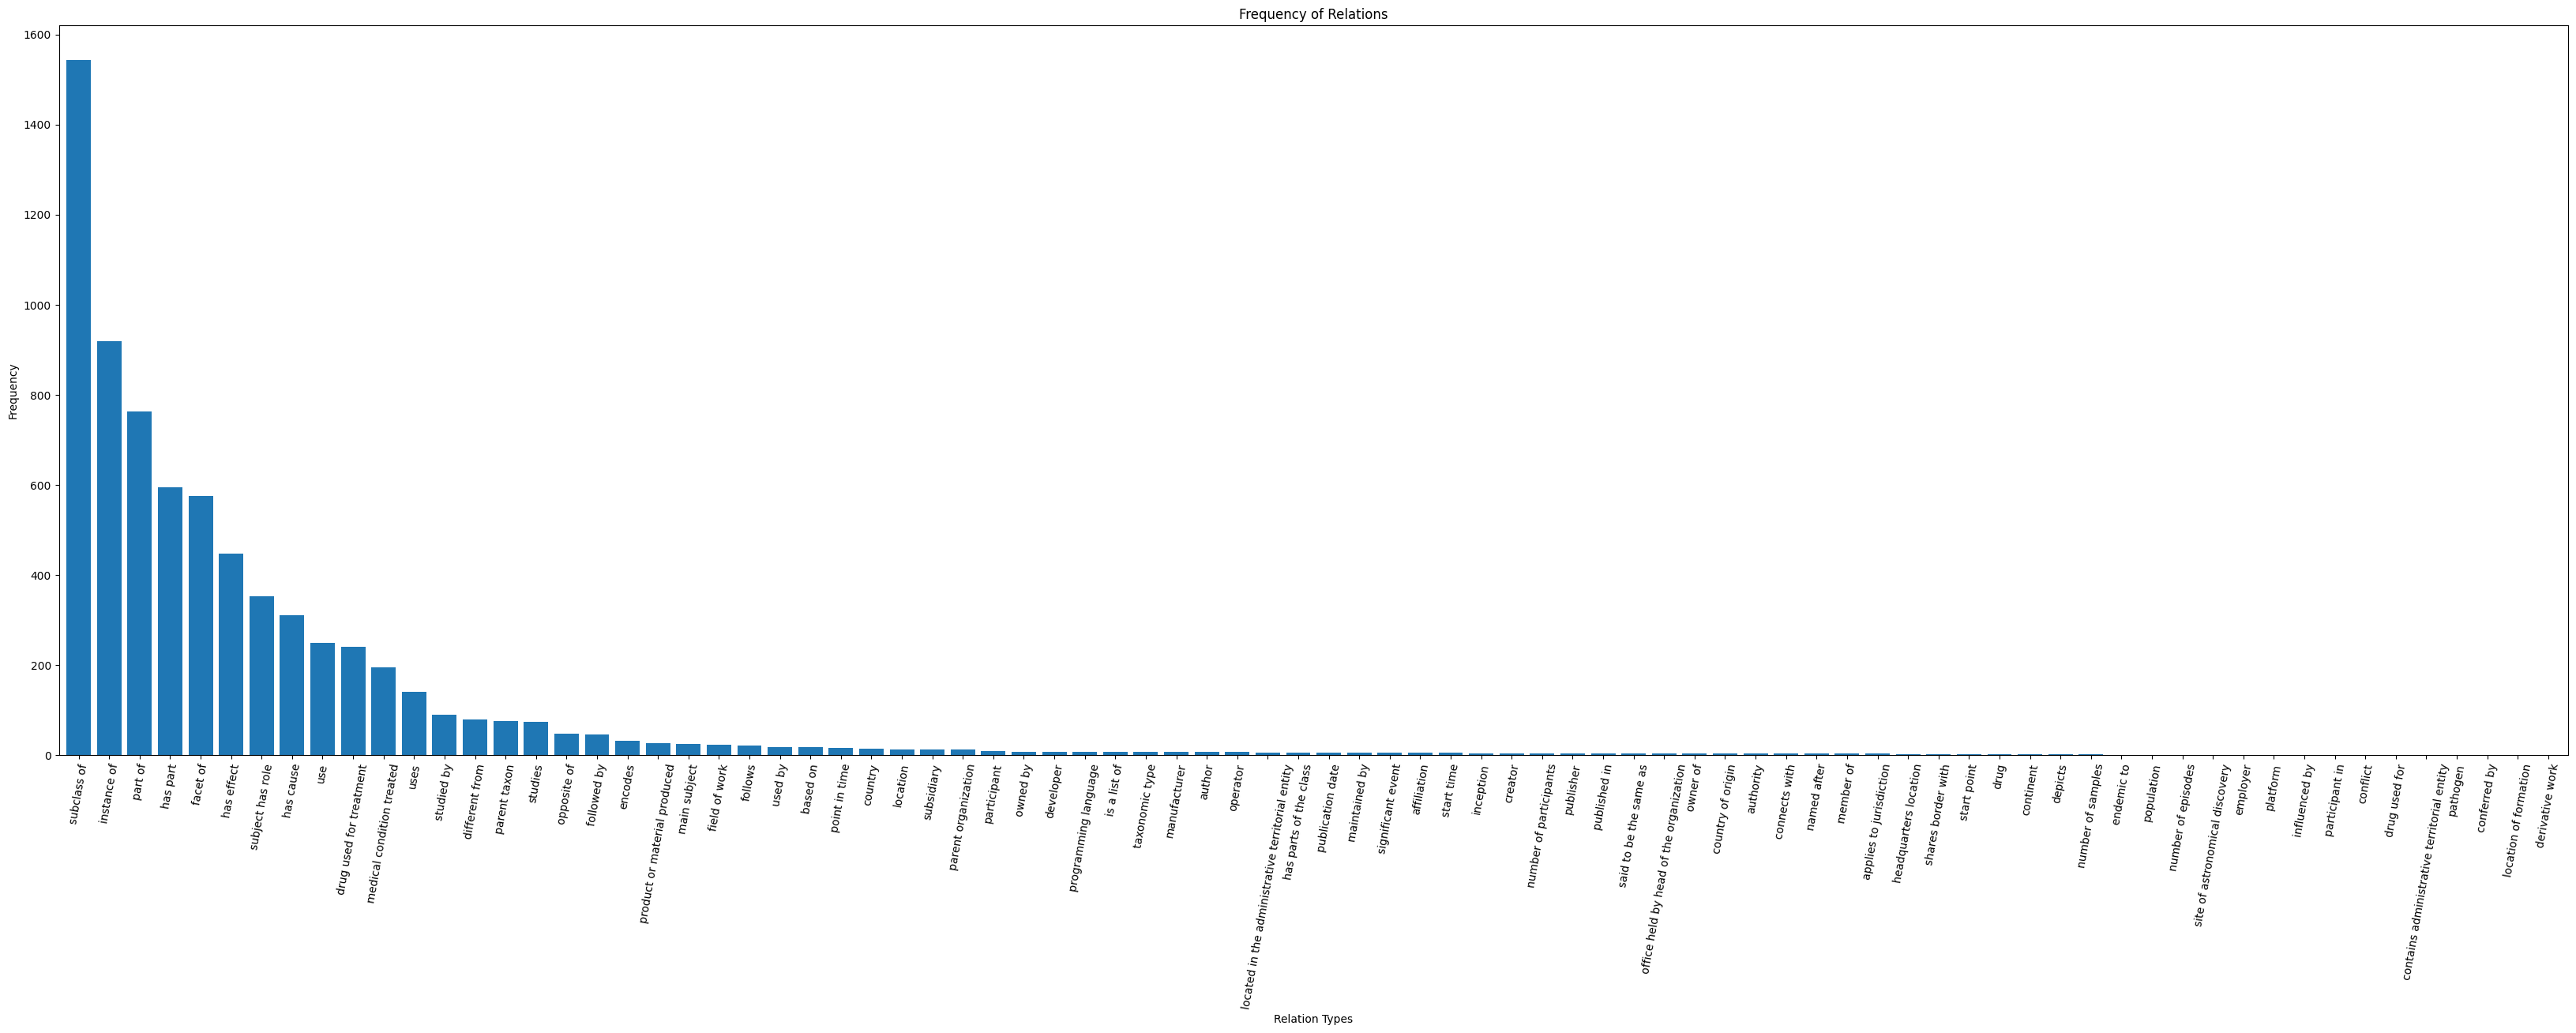

In [ ]:
plot_frequency(unique_triples_canonical_dedup_cleaned_df, 'relation', 'Relation Types', 'Frequency', 'Frequency of Relations')

## 8. Knowledge Graph

We will select a subset of five of the 82 relation types which are most obviously biomedical relation types and visualise the triples as a knowledge graph.

In [ ]:
# List of relations to filter
relations_to_keep = [
    'drug used for treatment',
    'medical condition treated',
    'drug',
    'pathogen',
    'drug used for'
]

In [ ]:
# load REBEL triples with canonicals
with open('2024-07-13_rebel_unique_triples_canonical_dedup_cleaned_df_7149.pickle', "rb") as f:
    rebel_triples_df = pickle.load(f)

In [ ]:
len(rebel_triples_df)

7149

In [ ]:
# Filter DataFrame for rows with specified relations
filtered_df = rebel_triples_df[rebel_triples_df['relation'].isin(relations_to_keep)]
filtered_df = filtered_df.reset_index(drop=True)

In [ ]:
len(filtered_df)

438

In [ ]:
filtered_df

,head,relation,tail
0,sars-cov-2,pathogen,immune system
1,amoebiasis,drug used for treatment,quinolone
2,hiv,drug used for treatment,lopinavir
3,human immunodeficiency virus-1 and 2 hiv,drug used for treatment,lopinavir
4,congenital disabilities,drug used for treatment,molnupiravir
...,...,...,...
433,remdesivir,medical condition treated,coronavirus
434,chloroquine,medical condition treated,coronavirus
435,cox-inhibitors,medical condition treated,inflammation
436,covid-19,medical condition treated,viral disease


The triple `'covid-19','medical condition treated','viral disease'` looks dubious as the head entity should be a drug, and is likely the result of an error in either the triple extraction or entity normalisation process.

Also, REBEL has not handled non-contiguous entities as `human immunodeficiency virus-1 and 2` have been identified as one entity instead  of `human immunodeficiency virus-1` and `human immunodeficiency virus-2`.

In [ ]:
with open('2024-07-13_filtered_df_438.pickle', "wb") as f:
    pickle.dump(filtered_df, f)

In [ ]:
filtered_df.to_csv('2024-07-13_rebel_filtered_triples_438.csv', index=False)

We will use the [`pyvis`](https://github.com/WestHealth/pyvis) library designed for quick generation of visual network graphs with minimal python code.

In [ ]:
def create_pyvis_graph(triples_df, output_file):
    # Initialise a pyvis network object
    net = Network(notebook=True,
                  cdn_resources="in_line",
                  directed=True,
                  select_menu=True,
                  filter_menu=True)

    # Add nodes and edges to the network
    for index, row in triples_df.iterrows():
        head = row['head']
        tail = row['tail']
        relation = row['relation']

        # Add nodes
        net.add_node(head, title=head, label=head)
        net.add_node(tail, title=tail, label=tail)

        # Add edge with the relation as the title
        net.add_edge(head, tail, title=relation, label=relation)

    # Print the number of nodes and edges
    print(f"Graph with {len(net.nodes)} nodes and {len(net.edges)} edges.")

    # Generate the graph and save to HTML file
    net.save_graph(output_file)

    # Display the graph
    display(HTML(output_file))

In [ ]:
create_pyvis_graph(filtered_df, 'rebel_filtered_graph.html')

Graph with 241 nodes and 438 edges.


## 9. Relation mapping to SemRep

[SemRep](https://lhncbc.nlm.nih.gov/ii/tools/SemRep_SemMedDB_SKR/SemRep.html) is an NLP system developed at the U.S. [National Library of Medicine](https://www.nlm.nih.gov/) that extracts semantic relations from biomedical text. It focuses on extracting semantic predications, or subject-predicate-object triples, from PubMed abstracts using linguistic principles and UMLS domain knowledge.

SemRep uses a subset of the 55 relations in the UMLS Semantic Network with redefinitions, additions, expansions and exclusions to construct a semantic predication gold standard.

We will define lists for REBEL and SemRep predicates and create a system message instructing the Llama3-70b model to map the 82 REBEL predicates to the SemRep predicates.






In [ ]:
relations = """

REBEL = [
    'subclass of', 'instance of', 'part of', 'has part', 'facet of', 'has effect', 'subject has role',
    'has cause', 'drug used for treatment', 'use', 'medical condition treated', 'uses', 'studied by',
    'parent taxon', 'different from', 'studies', 'opposite of', 'followed by', 'encodes',
    'product or material produced', 'main subject', 'field of work', 'follows', 'point in time', 'based on',
    'used by', 'country', 'location', 'subsidiary', 'parent organization', 'participant', 'owned by',
    'programming language', 'developer', 'is a list of', 'author', 'said to be the same as', 'operator',
    'located in the administrative territorial entity', 'taxonomic type', 'manufacturer', 'has parts of the class',
    'publication date', 'start time', 'significant event', 'maintained by', 'affiliation', 'number of participants',
    'creator', 'inception', 'publisher', 'office held by head of the organization', 'country of origin',
    'published in', 'applies to jurisdiction', 'owner of', 'authority', 'member of', 'named after', 'connects with',
    'continent', 'number of samples', 'location of formation', 'depicts', 'drug', 'start point', 'shares border with',
    'headquarters location', 'pathogen', 'influenced by', 'participant in', 'conferred by', 'conflict',
    'contains administrative territorial entity', 'drug used for', 'endemic to', 'platform', 'employer',
    'site of astronomical discovery', 'number of episodes', 'population', 'derivative work'
    ]

SemRep = [
    'ADMINISTERED_TO', 'AFFECTS', 'ASSOCIATED_WITH', 'AUGMENTS', 'CAUSES', 'COEXISTS_WITH',
    'COMPARED_WITH', 'COMPLICATES', 'CONVERTS_TO', 'DIAGNOSES', 'DISRUPTS', 'HIGHER_THAN',
    'INHIBITS', 'INTERACTS_WITH', 'ISA', 'LOCATION_OF', 'LOWER_THAN', 'MANIFESTATION_OF',
    'MEASURES', 'METHOD_OF', 'OCCURS_IN', 'PART_OF', 'PRECEDES', 'PREDISPOSES', 'PREVENTS',
    'PROCESS_OF', 'PRODUCES', 'SAME_AS', 'STIMULATES', 'TREATS', 'USES'
    ]

"""

In [ ]:
system_message = """

You are a biomedical annotator. Look at the two lists of relation types and map the relation types in the first list (REBEL) to those in the second list (SemRep).
Structure the output in the following format:

relation_mapping = {
    'subclass of': 'ISA',
    'instance of': 'ISA',
    ...}

- Do not invent relations that are not in SemRep
- If the relation is inverse, indicate this. For example 'has part': 'INVERSE_PART_OF' or 'has cause': 'CAUSED_BY'
- Do not add any additional explanations or formatting
"""

In [ ]:
prompt = [
    {"role": "system","content": system_message},
    {"role": "user", "content": relations}
]

In [ ]:
def map_relations(prompt):
    """Send one request and retrieve model's generation."""
    chat_completion = client.chat.completions.create(
        messages=prompt,
        model='llama3-70b-8192',
        temperature=0,
        max_tokens=8192,
        top_p=1,
        stop=None,
        stream=False,
        seed=42
    )
    return chat_completion.choices[0].message.content

In [ ]:
mapped_relations = map_relations(prompt)

In [ ]:
print(mapped_relations)

relation_mapping = {
    'subclass of': 'ISA',
    'instance of': 'ISA',
    'part of': 'PART_OF',
    'has part': 'INVERSE_PART_OF',
    'facet of': 'PART_OF',
    'has effect': 'AFFECTS',
    'subject has role': 'ASSOCIATED_WITH',
    'has cause': 'INVERSE_CAUSES',
    'drug used for treatment': 'TREATS',
    'use': 'USES',
    'medical condition treated': 'TREATS',
    'uses': 'USES',
    'studied by': 'METHOD_OF',
    'parent taxon': 'ISA',
    'different from': 'NOT SAME_AS',
    'studies': 'METHOD_OF',
    'opposite of': 'NOT SAME_AS',
    'followed by': 'PRECEDES',
    'encodes': 'PRODUCES',
    'product or material produced': 'PRODUCES',
    'main subject': 'ASSOCIATED_WITH',
    'field of work': 'ASSOCIATED_WITH',
    'follows': 'PRECEDES',
    'point in time': 'OCCURS_IN',
    'based on': 'SAME_AS',
    'used by': 'USES',
    'country': 'LOCATION_OF',
    'location': 'LOCATION_OF',
    'subsidiary': 'PART_OF',
    'parent organization': 'PART_OF',
    'participant': 'PART_OF'

In [ ]:
with open('2024-07-13_mapped_relations.pickle', "wb") as f:
    pickle.dump(mapped_relations, f)

The output broadly maps to the correct relations but further iterations to the prompt or manual curation would be necessary to handle inverse relations for incorrect mappings such as `'follows': 'PRECEDES'`. The relation would have to be negated (`NEG_<predicate>`).

There are also  instances where either the relation would have to change or the head and tail entities be transposed. For example, the model maps `'drug used for treatment': 'TREATS'` which would be incorrect for the triple `'hiv', 'drug used for treatment', 'lopinavir'`.

## 10. Add entity types and CUIs

We will add the `entity_type` and `entity_id` data extracted by KAZU during the NER and Linking stage to the REBEL triples data.

In [ ]:
# load KAZU sentences with entities only
with open('2024-05-10_kazu_entities_only_3447.pickle', 'rb') as f:
    kazu_entities_df = pickle.load(f)

In [ ]:
kazu_entities_df

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id
0,chembl:CHEMBL192,drug,sildenafil,38,48,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
1,HP:0100639,disease,male erectile dysfunction,53,78,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
2,MONDO:0005149,disease,pulmonary hypertension,83,105,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
3,chembl:CHEMBL894,drug,bupropion,144,153,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
4,chembl:CHEMBL468,drug,thalidomide,197,208,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
...,...,...,...,...,...,...,...,...
3442,STATO:0000569,measurement,score,4,9,The score for each drug is equal to the sum of...,f06e07ee624e49de824cb35e524cef19,PMC9556799
3443,covid,disease,SARS-CoV-2 infected,36,55,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799
3444,CL:0002063,cell_type,alveolar type II cells,89,111,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799
3445,African green monkey kidney cells,cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799


In [ ]:
kazu_entities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    3447 non-null   object
 1   entity_type  3447 non-null   object
 2   entity       3447 non-null   object
 3   span_start   3447 non-null   Int64 
 4   span_end     3447 non-null   Int64 
 5   text         3447 non-null   object
 6   idx          3447 non-null   object
 7   article_id   3447 non-null   object
dtypes: Int64(2), object(6)
memory usage: 222.3+ KB


In [ ]:
# load REBEL triples with canonicals
with open('2024-07-13_rebel_unique_triples_canonical_dedup_cleaned_df_7149.pickle', "rb") as f:
    rebel_triples_df = pickle.load(f)

In [ ]:
rebel_triples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7149 entries, 0 to 7148
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   head      7149 non-null   object
 1   relation  7149 non-null   object
 2   tail      7149 non-null   object
dtypes: object(3)
memory usage: 167.7+ KB


In [ ]:
# Normalise KAZU entity names to lowercase
kazu_entities_df['entity'] = kazu_entities_df['entity'].str.lower()

### 10.1 Rule-based dictionary lookup and fuzzy matching

We will create dictionaries with `key:value` pairs for `entity:entity_type` and `entity:entity_id` for easy lookup by a function which performs fuzzy matching of REBEL entities against KAZU entities using [`thefuzz`](https://github.com/seatgeek/thefuzz) string matching library.

If a match is found a tuple is returned where the first value is the entity type (or 'other' if not found), and the second value is the entity ID (or the original entity if not found in entity_id).



In [ ]:
# Create dictionaries for quick lookup
entity_to_type = kazu_entities_df.set_index('entity')['entity_type'].to_dict()
entity_to_id = kazu_entities_df.set_index('entity')['entity_id'].to_dict()

In [ ]:
# Function to get type and id or default values with fuzzy matching
def get_type_and_id(entity, entity_to_type, entity_to_id, threshold=80):
    # Perform fuzzy matching
    match = process.extractOne(entity, entity_to_type.keys(), score_cutoff=threshold)
    if match:
        matched_entity = match[0]
        return entity_to_type.get(matched_entity, 'other'), entity_to_id.get(matched_entity, entity)
    else:
        return 'other', entity

In [ ]:
%%time
# Iterate through the triples DataFrame and add new columns
rebel_triples_df['head_type'] = rebel_triples_df['head'].apply(lambda x: get_type_and_id(x, entity_to_type, entity_to_id)[0])
rebel_triples_df['head_id'] = rebel_triples_df['head'].apply(lambda x: get_type_and_id(x, entity_to_type, entity_to_id)[1])
rebel_triples_df['tail_type'] = rebel_triples_df['tail'].apply(lambda x: get_type_and_id(x, entity_to_type, entity_to_id)[0])
rebel_triples_df['tail_id'] = rebel_triples_df['tail'].apply(lambda x: get_type_and_id(x, entity_to_type, entity_to_id)[1])

CPU times: user 1min 19s, sys: 0 ns, total: 1min 19s
Wall time: 1min 24s


In [ ]:
# Reindex the DataFrame
rebel_triples_df = rebel_triples_df.reset_index(drop=True)

In [ ]:
with open('2024-07-13_rebel_triples_types_ids_df.pickle', "wb") as f:
    pickle.dump(rebel_triples_df, f)

In [ ]:
rebel_triples_df

,head,relation,tail,head_type,head_id,tail_type,tail_id
0,double-blind,use,safety,other,double-blind,gene,S
1,consensus among all approaches,instance of,consensus,other,consensus among all approaches,other,consensus
2,hydrogen,subclass of,atoms,drug,chembl:CHEMBL4297766,gene,S
3,distal airway,part of,lungs,cell_type,distal airway cells,gene,S
4,sepsis dataset,has part,b,disease,HP:0100806,disease,MONDO:0005737
...,...,...,...,...,...,...,...
7144,ards,has effect,sepsis,disease,MONDO:0006502,disease,HP:0100806
7145,network science,studies,ai,other,network science,gene,papain
7146,abiraterone,medical condition treated,covid-19,drug,chembl:CHEMBL254328,disease,covid
7147,genetic risk genes,subclass of,gene,other,genetic risk genes,disease,genetically related diseases


In [ ]:
rebel_triples_df.to_csv('2024-07-13_rebel_triples_types_ids.csv', index=False)

The triple extraction using REBEL resulted in entities which the KAZU API did not label as part of the NER step. Postprocessing using fuzzy matching reveals some inconsistencies including:

- 'lungs' being labelled 'gene' instead of 'anatomy'.
- 'ai', or artificial intelligence, being labelled as 'gene' with tail_id 'papain', perhaps because it is a substring.
- for the triple `'genetic risk genes', 'subclass of',	'gene'`, there is some confusion with the tail entity 'gene' being labelled 'disease' with tail_id 'genetically related diseases'.
- Letters such as S, N, DR and EC appear as head and tail id but are not valid ontology ids.
- for 'b' in triple `'sepsis dataset', 'has part', 'b'`, which refers to part b of a dataset, 'b' has been given tail_id `MONDO:0005737` which is actually the ontology id for Ebola hemorrhagic fever!




### 10.2 Rule-based dictionary lookup and regex patterns

We will amend the code to check whether entity_id values match a valid regex pattern for entity_id values in the KAZU DataFrame to ensure that these are valid ontology ids, else use the entity name.

In [ ]:
# Create dictionaries for quick lookup
entity_to_type = kazu_entities_df.set_index('entity')['entity_type'].to_dict()
entity_to_id = kazu_entities_df.set_index('entity')['entity_id'].to_dict()

We will define a regex pattern to match strings based on the following three conditions:

* Entirely numeric - to capture HGNC (HUGO Gene Nomenclature Committee) database IDs, as the prefix was not added during the NER and Linking step.

* In the format `Letters:LettersOrDigits`.

* The term 'covid' (case-insensitively).

```python
# Regular expression to validate the entity ID
valid_id_pattern = re.compile(r'^\d+$|^[A-Za-z]+:[A-Za-z0-9]+$|^(covid)$', re.IGNORECASE)
```

In [ ]:
# Function to get type and id or default values with fuzzy matching
def get_type_and_id(entity, entity_to_type, entity_to_id, threshold=80):
    match = process.extractOne(entity, entity_to_type.keys(), score_cutoff=threshold)
    if match:
        matched_entity = match[0]
        entity_type = entity_to_type.get(matched_entity, 'other')
        entity_id = entity_to_id.get(matched_entity, entity)

        # Check if the entity_id matches the valid_id_pattern
        if valid_id_pattern.match(entity_id):
            return entity_type, entity_id
    return 'other', entity

In [ ]:
# Iterate through the triples DataFrame and add new columns
rebel_triples_df['head_type'] = rebel_triples_df['head'].apply(lambda x: get_type_and_id(x, entity_to_type, entity_to_id, threshold=80)[0])
rebel_triples_df['head_id'] = rebel_triples_df['head'].apply(lambda x: get_type_and_id(x, entity_to_type, entity_to_id, threshold=80)[1])
rebel_triples_df['tail_type'] = rebel_triples_df['tail'].apply(lambda x: get_type_and_id(x, entity_to_type, entity_to_id, threshold=80)[0])
rebel_triples_df['tail_id'] = rebel_triples_df['tail'].apply(lambda x: get_type_and_id(x, entity_to_type, entity_to_id, threshold=80)[1])


In [ ]:
# Count occurrences of head_type with value 'other'
head_type_counts = rebel_triples_df['head_type'].value_counts()
count_other_head_type = head_type_counts.get('other', 0)

print(f"Count of head_type with value 'other': {count_other_head_type}")

Count of head_type with value 'other': 3590


In [ ]:
# Count occurrences of tail_type with value 'other'
tail_type_counts = rebel_triples_df['tail_type'].value_counts()
count_other_tail_type = tail_type_counts.get('other', 0)

print(f"Count of tail_type with value 'other': {count_other_tail_type}")

Count of tail_type with value 'other': 4134


In [ ]:
# Additional Debugging Information for invalid IDs
invalid_head_ids = rebel_triples_df[~rebel_triples_df['head_id'].apply(lambda x: valid_id_pattern.match(x) is not None)]
invalid_tail_ids = rebel_triples_df[~rebel_triples_df['tail_id'].apply(lambda x: valid_id_pattern.match(x) is not None)]

print("Invalid head IDs:")
invalid_head_ids[['head', 'head_type', 'head_id']]

Invalid head IDs:


,head,head_type,head_id
0,double-blind,other,double-blind
1,consensus among all approaches,other,consensus among all approaches
3,distal airway,other,distal airway
8,human protein-protein interactions,other,human protein-protein interactions
9,polyclonal,other,polyclonal
...,...,...,...
7135,vaccine,other,vaccine
7140,moieties,other,moieties
7145,network science,other,network science
7147,genetic risk genes,other,genetic risk genes


In [ ]:
invalid_head_ids

,head,relation,tail,head_type,head_id,tail_type,tail_id
0,double-blind,use,safety,other,double-blind,other,safety
1,consensus among all approaches,instance of,consensus,other,consensus among all approaches,other,consensus
3,distal airway,part of,lungs,other,distal airway,other,lungs
8,human protein-protein interactions,instance of,ppi,other,human protein-protein interactions,gene,909
9,polyclonal,subclass of,antibody,other,polyclonal,go_cc,GO:0042571
...,...,...,...,...,...,...,...
7135,vaccine,has cause,infectious diseases,other,vaccine,disease,MONDO:0005550
7140,moieties,has part,basic residues,other,moieties,other,basic residues
7145,network science,studies,ai,other,network science,other,ai
7147,genetic risk genes,subclass of,gene,other,genetic risk genes,other,gene


In [ ]:
print("Invalid tail IDs:")
invalid_tail_ids[['tail', 'tail_type', 'tail_id']]

Invalid tail IDs:


,tail,tail_type,tail_id
0,safety,other,safety
1,consensus,other,consensus
2,atoms,other,atoms
3,lungs,other,lungs
11,rna transcription,other,rna transcription
...,...,...,...
7140,basic residues,other,basic residues
7142,pandemic,other,pandemic
7145,ai,other,ai
7147,gene,other,gene


In [ ]:
invalid_tail_ids

,head,relation,tail,head_type,head_id,tail_type,tail_id
0,double-blind,use,safety,other,double-blind,other,safety
1,consensus among all approaches,instance of,consensus,other,consensus among all approaches,other,consensus
2,hydrogen,subclass of,atoms,drug,chembl:CHEMBL4297766,other,atoms
3,distal airway,part of,lungs,other,distal airway,other,lungs
11,rna-dependent rna polymerase,subclass of,rna transcription,other,rna-dependent rna polymerase,other,rna transcription
...,...,...,...,...,...,...,...
7140,moieties,has part,basic residues,other,moieties,other,basic residues
7142,sars-cov-2,has effect,pandemic,disease,covid,other,pandemic
7145,network science,studies,ai,other,network science,other,ai
7147,genetic risk genes,subclass of,gene,other,genetic risk genes,other,gene


In [ ]:
rebel_triples_df

,head,relation,tail,head_type,head_id,tail_type,tail_id
0,double-blind,use,safety,other,double-blind,other,safety
1,consensus among all approaches,instance of,consensus,other,consensus among all approaches,other,consensus
2,hydrogen,subclass of,atoms,drug,chembl:CHEMBL4297766,other,atoms
3,distal airway,part of,lungs,other,distal airway,other,lungs
4,sepsis dataset,has part,b,disease,HP:0100806,disease,MONDO:0005737
...,...,...,...,...,...,...,...
7144,ards,has effect,sepsis,disease,MONDO:0006502,disease,HP:0100806
7145,network science,studies,ai,other,network science,other,ai
7146,abiraterone,medical condition treated,covid-19,drug,chembl:CHEMBL254328,disease,covid
7147,genetic risk genes,subclass of,gene,other,genetic risk genes,other,gene


In [ ]:
with open('2024-07-14_rebel_triples_type_id_7149.pickle', "wb") as f:
    pickle.dump(rebel_triples_df, f)

In [ ]:
rebel_triples_df.to_csv('2024-07-14_rebel_triples_type_id_7149.csv', index=False)

We will prefix the digits for the HGNC entity IDs with `hgnc.genegroup:` so that they can be appended to bioregistry.io/ and resolve to the correct entry in the database.

In [ ]:
def add_hgnc(entity, entity_id):
    # Check if the entity_id is digits and not matching the entity
    if entity_id.isdigit() and entity != entity_id:
        return f"hgnc.genegroup:{entity_id}"
    return entity_id

def normalise_data(df):
    df['head_id'] = df.apply(lambda row: add_hgnc(row['head'], row['head_id']), axis=1)
    df['tail_id'] = df.apply(lambda row: add_hgnc(row['tail'], row['tail_id']), axis=1)
    return df

In [ ]:
rebel_triples_df_updated = normalise_data(rebel_triples_df)

In [ ]:
len(rebel_triples_df_updated)

7149

In [ ]:
filtered_df = rebel_triples_df_updated[
    rebel_triples_df_updated['head_id'].str.contains('hgnc.genegroup:') |
    rebel_triples_df_updated['tail_id'].str.contains('hgnc.genegroup:')
]

filtered_df

,head,relation,tail,head_type,head_id,tail_type,tail_id
5,protocadherin,encodes,pcdh9,gene,hgnc.genegroup:19,gene,ensembl:ENSG00000184226
7,mapk,has part,p38 mapk,gene,hgnc.genegroup:651,gene,ensembl:ENSG00000112062
8,human protein-protein interactions,instance of,ppi,other,human protein-protein interactions,gene,hgnc.genegroup:909
50,niran domain,subclass of,nucleotidyltransferase,other,niran domain,gene,hgnc.genegroup:389
117,eqtls,part of,crispr,other,eqtls,gene,hgnc.genegroup:1355
...,...,...,...,...,...,...,...
6889,ppi,subclass of,network proximity analysis,gene,hgnc.genegroup:909,measurement,STATO:0000155
6934,sars-cov-2,has effect,ppi,disease,covid,gene,hgnc.genegroup:909
7031,in vitro,different from,in silico,other,in vitro,gene,hgnc.genegroup:601
7062,string,instance of,ppi databases,other,string,gene,hgnc.genegroup:909


In [ ]:
len(filtered_df)

164

In [ ]:
with open('2024-11-02_rebel_triples_df_updated_7149.pickle', "wb") as f:
    pickle.dump(rebel_triples_df_updated, f)

In [ ]:
rebel_triples_df_updated.to_csv('2024-11-02_rebel_triples_df_updated_7149.csv', index=False)

In [ ]:
rebel_triples_df_updated

,head,relation,tail,head_type,head_id,tail_type,tail_id
0,double-blind,use,safety,other,double-blind,other,safety
1,consensus among all approaches,instance of,consensus,other,consensus among all approaches,other,consensus
2,hydrogen,subclass of,atoms,drug,chembl:CHEMBL4297766,other,atoms
3,distal airway,part of,lungs,other,distal airway,other,lungs
4,sepsis dataset,has part,b,disease,HP:0100806,disease,MONDO:0005737
...,...,...,...,...,...,...,...
7144,ards,has effect,sepsis,disease,MONDO:0006502,disease,HP:0100806
7145,network science,studies,ai,other,network science,other,ai
7146,abiraterone,medical condition treated,covid-19,drug,chembl:CHEMBL254328,disease,covid
7147,genetic risk genes,subclass of,gene,other,genetic risk genes,other,gene


### References


* Zhang, J. et al. (2024). A Study of Biomedical Relation Extraction Using GPT Models. In *AMIA Summits on Translational Science Proceedings*, 2024:391-400. PMCID: [PMC11141827](https://pmc.ncbi.nlm.nih.gov/articles/PMC11141827/); PMID: [38827097](https://pubmed.ncbi.nlm.nih.gov/38827097/)

* Huguet Cabot, P. L., & Navigli, R. (2021). REBEL: Relation extraction by End-to-end language generation. In *Findings of the Association for Computational Linguistics: EMNLP 2021*, 2370-2381. Association for Computational Linguistics. [doi:10.18653/v1/2021.findings-emnlp.204](https://doi.org/10.18653/v1/2021.findings-emnlp.204)


* https://github.com/Babelscape/rebel


* https://huggingface.co/Babelscape/rebel-large


* https://huggingface.co/blog/how-to-generate


* https://medium.com/@jingying.h95/beam-search-1e875fd59ab4


* https://d2l.ai/chapter_recurrent-modern/beam-search.html

* https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/Llamaindex-rebel-neo4j.ipynb


* Bratanič, T. (2024). [Graph Algorithms for Data Science](https://www.manning.com/books/graph-algorithms-for-data-science)


* https://towardsdatascience.com/relation-extraction-with-llama3-models-f8bc41858b9e


* https://medium.com/@haiyangli_38602/make-meaningful-knowledge-graph-from-opensource-rebel-model-6f9729a55527


* https://groq.com/


* https://console.groq.com/playground


* Kilicoglu, H. et al. (2011). Constructing a semantic predication gold standard from the biomedical literature. *BMC Bioinformatics*, *12*:486 (2011). [doi:10.1186/1471-2105-12-486](https://doi.org/10.1186/1471-2105-12-486)


* Kilicoglu, H. et al. (2020). Broad-coverage biomedical relation extraction with SemRep. *BMC Bioinformatics*, *21*:188 (2020). [doi:10.1186/s12859-020-3517-7](https://doi.org/10.1186/s12859-020-3517-7)

* [SemRep ontology and indicator rules](https://semrep.nlm.nih.gov/GoldStandard.html)

